# Import packages

In [29]:
#%pip install datasets
#%pip install accelerate -U
#%pip install transformers[torch]

Note: you may need to restart the kernel to use updated packages.


In [14]:
# General libraries
import os
import time
import multiprocessing
import warnings
import pickle
import re

# Data handling and visualization
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# NLP
from gensim.parsing.preprocessing import STOPWORDS, strip_punctuation, strip_multiple_whitespaces, remove_stopwords, strip_short

# Scikit-learn
from sklearn.model_selection import train_test_split
from tqdm import tqdm

# Pytorch
import torch

# Others
from datasets import Dataset,load_dataset
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset
from torch.optim import AdamW
from torch.optim.lr_scheduler import ReduceLROnPlateau, StepLR
from transformers import AutoTokenizer, DistilBertForSequenceClassification
import tensorflow as tf
import joblib
from sklearn.preprocessing import StandardScaler

# Load data

In [3]:
# Get all training data files
path = '../datasets/distilbert_data/train/'
files = [file for file in os.listdir(path) if file.endswith('text_clean.csv')]
files

['NetCashProvidedByUsedInInvestingActivities_train__text_clean.csv',
 'EBIT_train__text_clean.csv',
 'NetCashProvidedByUsedInFinancingActivities_train__text_clean.csv',
 'RevenueFromContractWithCustomerExcludingAssessedTax_train__text_clean.csv',
 'NetIncomeLoss_train__text_clean.csv',
 'EarningsPerShareDiluted_train__text_clean.csv']

In [4]:
# Get all training data files
fb_path = '../datasets/finbert_data/train/'
fb_files = [file for file in os.listdir(fb_path) if file.endswith('text_clean.csv')]
fb_files

['NetCashProvidedByUsedInInvestingActivities_train__text_clean.csv',
 'EBIT_train__text_clean.csv',
 'NetCashProvidedByUsedInFinancingActivities_train__text_clean.csv',
 'RevenueFromContractWithCustomerExcludingAssessedTax_train__text_clean.csv',
 'NetIncomeLoss_train__text_clean.csv',
 'EarningsPerShareDiluted_train__text_clean.csv']

In [12]:
# Load first data
df = pd.read_csv(path + files[0])
df.head()

,text,item,cik,year,val
0,Management considers several factors in assess...,item_7,922224,2020,5429000000
1,We estimate the fair values of the assets acqu...,item_7,1020569,2020,4147270000
2,If actual future taxable income differs from o...,item_7,1050915,2016,7651319000
3,The Company expects that it will be subject to...,item_7,29905,2017,6820886000
4,If all of our accumulated unrepatriated Indian...,item_7,1058290,2019,16783000000


In [6]:
# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 4 GPU(s) available.
We will use the GPU: Tesla V100-SXM2-32GB


# Initialize model and tokenizer

In [5]:
model = DistilBertForSequenceClassification.from_pretrained('yiyanghkust/finbert-pretrain', num_labels = 1)
tokenizer = AutoTokenizer.from_pretrained('yiyanghkust/finbert-pretrain')

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at yiyanghkust/finbert-pretrain and are newly initialized: ['transformer.layer.4.attention.q_lin.weight', 'transformer.layer.4.attention.k_lin.bias', 'transformer.layer.3.output_layer_norm.weight', 'transformer.layer.10.attention.v_lin.weight', 'transformer.layer.3.ffn.lin1.bias', 'transformer.layer.4.output_layer_norm.bias', 'transformer.layer.8.ffn.lin2.bias', 'transformer.layer.7.attention.v_lin.bias', 'transformer.layer.11.ffn.lin1.bias', 'transformer.layer.0.attention.v_lin.bias', 'transformer.layer.6.attention.out_lin.bias', 'transformer.layer.6.ffn.lin1.weight', 'transformer.layer.0.attention.out_lin.bias', 'transformer.layer.0.ffn.lin1.weight', 'transformer.layer.7.sa_layer_norm.bias', 'transformer.layer.2.attention.v_lin.bias', 'transformer.layer.2.attention.v_lin.weight', 'transformer.layer.3.ffn.lin2.weight', 'transformer.layer.0.output_layer_norm.bias', 'transformer.layer.6.ou

# Tokenize text and prepare labeled datasets

In [7]:
def prepare_labeled_datasets(tokenizer, model, length, texts, labelsset):
  inputs=[]
  labels=[]
  for i in range(len(labelsset)):
    input=torch.tensor([tokenizer.encode(texts[i], padding='max_length',truncation=True, max_length=length)]).to(device) # Apply the tokenizer to get the token ids for each text, transform to tensors and send to GPU device
    label= torch.tensor([labelsset[i]]).to(device) # send the labels to the GPU device
    inputs.append(input)
    labels.append(label)
  inputs=torch.cat(inputs)  # add to the list of tensors
  labels=torch.cat(labels)  
  dataset = TensorDataset(inputs, labels) # Generate a labeled Tensor-Dataset for training
  return dataset

# Train models

In [8]:
def finbert_regressor():
    model = DistilBertForSequenceClassification.from_pretrained('yiyanghkust/finbert-pretrain', num_labels = 1)
    tokenizer = AutoTokenizer.from_pretrained('yiyanghkust/finbert-pretrain')
    return model, tokenizer

### Finbert regressor with CV

In [9]:
def loss_function(predictions, labels):
    mse_predictions_labels = torch.nn.functional.mse_loss(predictions.view(-1), labels.view(-1).float())
    mean_labels = torch.mean(labels.float())
    mse_labels_mean = torch.nn.functional.mse_loss(labels.view(-1).float(), mean_labels.expand_as(labels).view(-1))
    rse = mse_predictions_labels / mse_labels_mean
    return rse

In [11]:
from sklearn.model_selection import KFold

def train_finbert_regressor(model, tokenizer, dataset, epochs=10, initial_lr=0.001, eps=1e-8, batch_size=16, cv=5, patience=3):
    optimizer = torch.optim.AdamW(model.parameters(), lr=initial_lr, eps=eps)
    
    training_stats = []
    kfold = KFold(n_splits=cv, shuffle=True, random_state=42)  # Define the number of folds
    
    best_val_loss_overall = np.inf # Set initial best validation loss to infinity
    best_model_overall = None
    best_epoch_overall = 0
    best_fold_overall = 0
    all_train_losses = []
    all_val_losses = []
    
    for fold, (train_idx, val_idx) in enumerate(kfold.split(dataset)):
        #print(f"Fold {fold + 1}")
        train_subset = torch.utils.data.Subset(dataset, train_idx)
        val_subset = torch.utils.data.Subset(dataset, val_idx)

        train_loader = torch.utils.data.DataLoader(train_subset, batch_size=batch_size, shuffle=True)
        val_loader = torch.utils.data.DataLoader(val_subset, batch_size=batch_size)

        best_val_loss = np.inf
        train_losses = []
        val_losses = []
        best_epoch = 0
        early_stopping_counter = 0
        for epoch in range(epochs):
            model.train()
            train_loss = 0

            for step, batch in enumerate(train_loader):
                b_input_ids = batch[0].to(device)
                b_labels = batch[1].to(device)
                optimizer.zero_grad()
                b_outputs = model(input_ids=b_input_ids, labels=b_labels)[1] # Prepare outputs for loss function
                loss = loss_function(b_outputs, b_labels) # Calculate loss (RSE)
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
                optimizer.step()
                train_loss += loss.item()
            
            avg_train_loss = train_loss / len(train_loader)
            train_losses.append(avg_train_loss)

            model.eval()
            with torch.no_grad():
                val_loss = 0

                for batch in val_loader:
                    input_ids, labels = batch
                    input_ids.to(device)
                    labels.to(device)

                    outputs = model(input_ids=input_ids, labels=labels)
                    # Caclulate loss (RSE)
                    loss = loss_function(outputs[1], labels)
                    val_loss += loss.item()

                avg_val_loss = val_loss / len(val_loader)
                val_losses.append(avg_val_loss)
                
                if avg_val_loss < best_val_loss:
                    best_val_loss = avg_val_loss
                    best_epoch = epoch + 1
                    early_stopping_counter = 0
                    best_fold = fold + 1
                    best_model = model
                else:
                    early_stopping_counter += 1
                    if early_stopping_counter >= patience:
                        #print(f"Early stopping at epoch {epoch + 1} in fold {fold + 1}")
                        break
            
            

            training_stats.append({
                'Fold': fold + 1,
                'Epoch': epoch + 1,
                'Training Loss': avg_train_loss,
                'Valid. Loss': avg_val_loss,
            })
        #print(f"Fold {fold + 1} - Best Validation Loss: {best_val_loss} at Epoch: {best_epoch}")
    
        # Save losses and model for this fold
        all_train_losses.append(train_losses)
        all_val_losses.append(val_losses)
        
        # Save the best model for this fold
        if best_val_loss < best_val_loss_overall:
            best_val_loss_overall = best_val_loss
            best_model_overall = best_model
            best_epoch_overall = best_epoch
            best_fold_overall = best_fold
    return best_model_overall, best_val_loss_overall, best_fold_overall, all_train_losses, all_val_losses, training_stats

In [12]:
# Plot the learning curve from training_stats, filtered by fold
def plot_learning_curve(training_stats, fold):
    df = pd.DataFrame(training_stats)
    df = df[df['Fold'] == fold]
    fig, ax = plt.subplots(figsize=(12, 8))
    ax.plot(df['Epoch'], df['Training Loss'], label='Training Loss')
    ax.plot(df['Epoch'], df['Valid. Loss'], label='Validation Loss')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    ax.set_title(f'Learning Curve (Fold {fold})')
    ax.legend()
    plt.show()

### CV on all DistilBERT data



--------------START TRAINING MODEL FOR NetCashProvidedByUsedInInvestingActivities--------------


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at yiyanghkust/finbert-pretrain and are newly initialized: ['transformer.layer.3.ffn.lin2.weight', 'transformer.layer.4.attention.q_lin.weight', 'transformer.layer.1.attention.out_lin.bias', 'transformer.layer.10.sa_layer_norm.weight', 'transformer.layer.5.sa_layer_norm.bias', 'transformer.layer.8.attention.q_lin.bias', 'transformer.layer.3.output_layer_norm.weight', 'transformer.layer.5.attention.out_lin.bias', 'transformer.layer.5.ffn.lin2.bias', 'transformer.layer.9.sa_layer_norm.weight', 'transformer.layer.11.attention.q_lin.weight', 'transformer.layer.7.sa_layer_norm.bias', 'transformer.layer.10.output_layer_norm.bias', 'transformer.layer.8.attention.q_lin.weight', 'pre_classifier.weight', 'transformer.layer.9.ffn.lin2.bias', 'classifier.weight', 'transformer.layer.1.ffn.lin1.bias', 'transformer.layer.4.attention.v_lin.weight', 'transformer.layer.5.ffn.lin1.bias', 'transformer.layer.

Results from the best model
Fold with best validation RSE: 4
Best validation RSE: 0.97
Time: 31.16 seconds


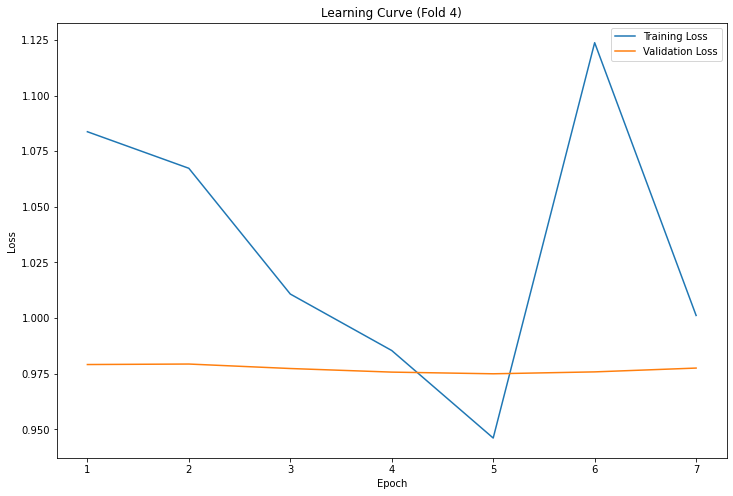

--------------DONE TRAINING MODEL FOR NetCashProvidedByUsedInInvestingActivities--------------




pytorch_model.bin:   0%|          | 0.00/439M [00:00<?, ?B/s]



--------------START TRAINING MODEL FOR EBIT--------------


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at yiyanghkust/finbert-pretrain and are newly initialized: ['transformer.layer.3.ffn.lin2.weight', 'transformer.layer.4.attention.q_lin.weight', 'transformer.layer.1.attention.out_lin.bias', 'transformer.layer.10.sa_layer_norm.weight', 'transformer.layer.5.sa_layer_norm.bias', 'transformer.layer.8.attention.q_lin.bias', 'transformer.layer.3.output_layer_norm.weight', 'transformer.layer.5.attention.out_lin.bias', 'transformer.layer.5.ffn.lin2.bias', 'transformer.layer.9.sa_layer_norm.weight', 'transformer.layer.11.attention.q_lin.weight', 'transformer.layer.7.sa_layer_norm.bias', 'transformer.layer.10.output_layer_norm.bias', 'transformer.layer.8.attention.q_lin.weight', 'pre_classifier.weight', 'transformer.layer.9.ffn.lin2.bias', 'classifier.weight', 'transformer.layer.1.ffn.lin1.bias', 'transformer.layer.4.attention.v_lin.weight', 'transformer.layer.5.ffn.lin1.bias', 'transformer.layer.

Results from the best model
Fold with best validation RSE: 2
Best validation RSE: 1.02
Time: 204.29 seconds


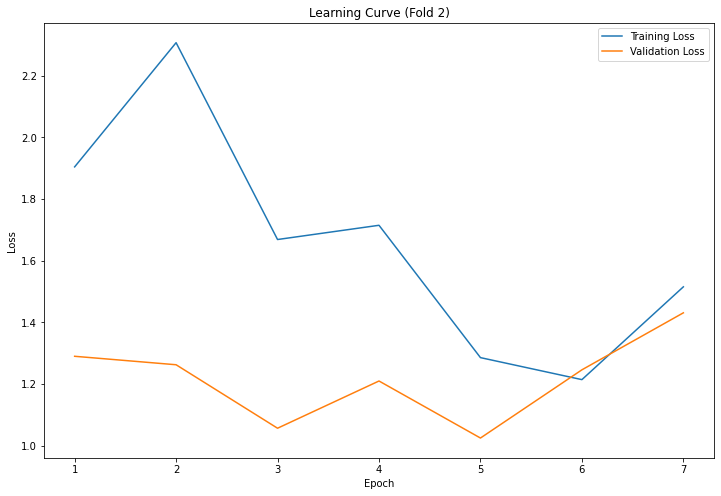

--------------DONE TRAINING MODEL FOR EBIT--------------




pytorch_model.bin:   0%|          | 0.00/439M [00:00<?, ?B/s]



--------------START TRAINING MODEL FOR NetCashProvidedByUsedInFinancingActivities--------------


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at yiyanghkust/finbert-pretrain and are newly initialized: ['transformer.layer.3.ffn.lin2.weight', 'transformer.layer.4.attention.q_lin.weight', 'transformer.layer.1.attention.out_lin.bias', 'transformer.layer.10.sa_layer_norm.weight', 'transformer.layer.5.sa_layer_norm.bias', 'transformer.layer.8.attention.q_lin.bias', 'transformer.layer.3.output_layer_norm.weight', 'transformer.layer.5.attention.out_lin.bias', 'transformer.layer.5.ffn.lin2.bias', 'transformer.layer.9.sa_layer_norm.weight', 'transformer.layer.11.attention.q_lin.weight', 'transformer.layer.7.sa_layer_norm.bias', 'transformer.layer.10.output_layer_norm.bias', 'transformer.layer.8.attention.q_lin.weight', 'pre_classifier.weight', 'transformer.layer.9.ffn.lin2.bias', 'classifier.weight', 'transformer.layer.1.ffn.lin1.bias', 'transformer.layer.4.attention.v_lin.weight', 'transformer.layer.5.ffn.lin1.bias', 'transformer.layer.

Results from the best model
Fold with best validation RSE: 0
Best validation RSE: inf
Time: 12.52 seconds


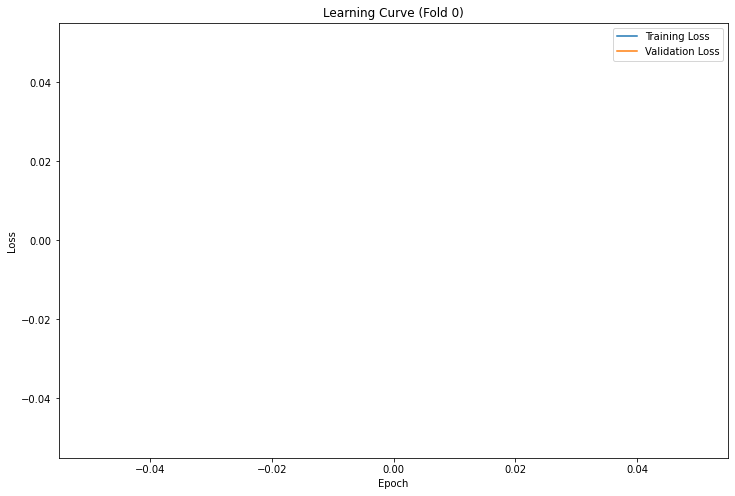

--------------DONE TRAINING MODEL FOR NetCashProvidedByUsedInFinancingActivities--------------


No model available


--------------START TRAINING MODEL FOR RevenueFromContractWithCustomerExcludingAssessedTax--------------


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at yiyanghkust/finbert-pretrain and are newly initialized: ['transformer.layer.3.ffn.lin2.weight', 'transformer.layer.4.attention.q_lin.weight', 'transformer.layer.1.attention.out_lin.bias', 'transformer.layer.10.sa_layer_norm.weight', 'transformer.layer.5.sa_layer_norm.bias', 'transformer.layer.8.attention.q_lin.bias', 'transformer.layer.3.output_layer_norm.weight', 'transformer.layer.5.attention.out_lin.bias', 'transformer.layer.5.ffn.lin2.bias', 'transformer.layer.9.sa_layer_norm.weight', 'transformer.layer.11.attention.q_lin.weight', 'transformer.layer.7.sa_layer_norm.bias', 'transformer.layer.10.output_layer_norm.bias', 'transformer.layer.8.attention.q_lin.weight', 'pre_classifier.weight', 'transformer.layer.9.ffn.lin2.bias', 'classifier.weight', 'transformer.layer.1.ffn.lin1.bias', 'transformer.layer.4.attention.v_lin.weight', 'transformer.layer.5.ffn.lin1.bias', 'transformer.layer.

Results from the best model
Fold with best validation RSE: 3
Best validation RSE: 0.28
Time: 7865.02 seconds


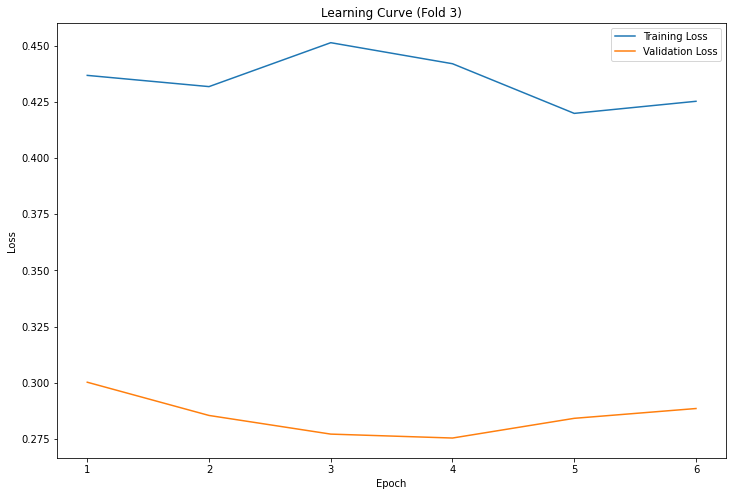

--------------DONE TRAINING MODEL FOR RevenueFromContractWithCustomerExcludingAssessedTax--------------




pytorch_model.bin:   0%|          | 0.00/439M [00:00<?, ?B/s]



--------------START TRAINING MODEL FOR NetIncomeLoss--------------


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at yiyanghkust/finbert-pretrain and are newly initialized: ['transformer.layer.3.ffn.lin2.weight', 'transformer.layer.4.attention.q_lin.weight', 'transformer.layer.1.attention.out_lin.bias', 'transformer.layer.10.sa_layer_norm.weight', 'transformer.layer.5.sa_layer_norm.bias', 'transformer.layer.8.attention.q_lin.bias', 'transformer.layer.3.output_layer_norm.weight', 'transformer.layer.5.attention.out_lin.bias', 'transformer.layer.5.ffn.lin2.bias', 'transformer.layer.9.sa_layer_norm.weight', 'transformer.layer.11.attention.q_lin.weight', 'transformer.layer.7.sa_layer_norm.bias', 'transformer.layer.10.output_layer_norm.bias', 'transformer.layer.8.attention.q_lin.weight', 'pre_classifier.weight', 'transformer.layer.9.ffn.lin2.bias', 'classifier.weight', 'transformer.layer.1.ffn.lin1.bias', 'transformer.layer.4.attention.v_lin.weight', 'transformer.layer.5.ffn.lin1.bias', 'transformer.layer.

Results from the best model
Fold with best validation RSE: 9
Best validation RSE: 0.24
Time: 8346.07 seconds


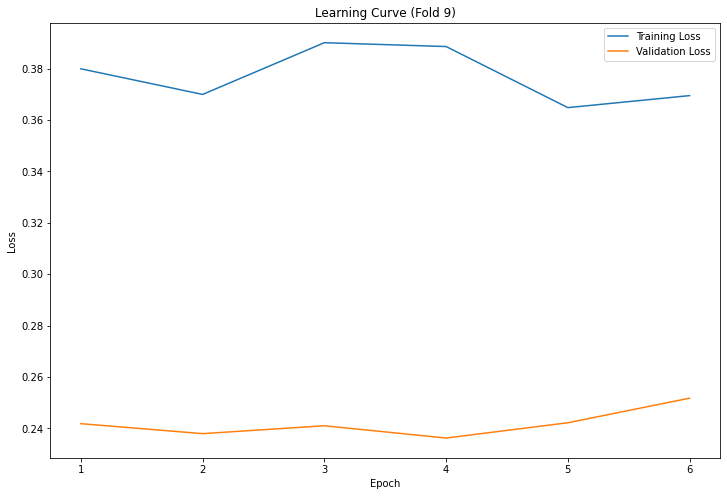

--------------DONE TRAINING MODEL FOR NetIncomeLoss--------------




pytorch_model.bin:   0%|          | 0.00/439M [00:00<?, ?B/s]



--------------START TRAINING MODEL FOR EarningsPerShareDiluted--------------


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at yiyanghkust/finbert-pretrain and are newly initialized: ['transformer.layer.3.ffn.lin2.weight', 'transformer.layer.4.attention.q_lin.weight', 'transformer.layer.1.attention.out_lin.bias', 'transformer.layer.10.sa_layer_norm.weight', 'transformer.layer.5.sa_layer_norm.bias', 'transformer.layer.8.attention.q_lin.bias', 'transformer.layer.3.output_layer_norm.weight', 'transformer.layer.5.attention.out_lin.bias', 'transformer.layer.5.ffn.lin2.bias', 'transformer.layer.9.sa_layer_norm.weight', 'transformer.layer.11.attention.q_lin.weight', 'transformer.layer.7.sa_layer_norm.bias', 'transformer.layer.10.output_layer_norm.bias', 'transformer.layer.8.attention.q_lin.weight', 'pre_classifier.weight', 'transformer.layer.9.ffn.lin2.bias', 'classifier.weight', 'transformer.layer.1.ffn.lin1.bias', 'transformer.layer.4.attention.v_lin.weight', 'transformer.layer.5.ffn.lin1.bias', 'transformer.layer.

Results from the best model
Fold with best validation RSE: 7
Best validation RSE: 0.81
Time: 376.01 seconds


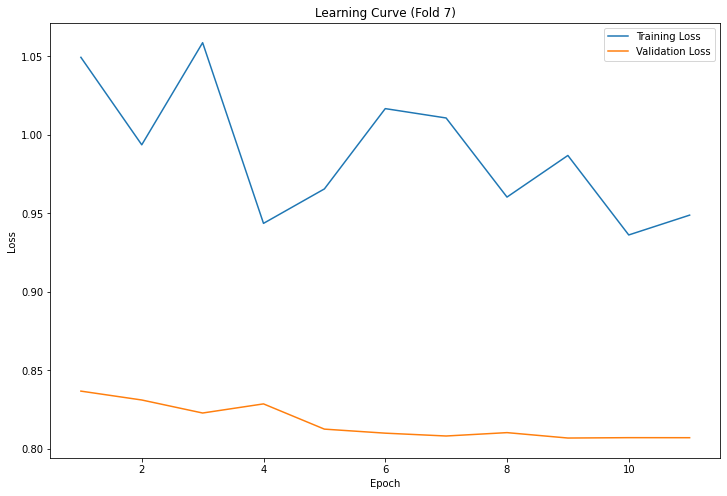

--------------DONE TRAINING MODEL FOR EarningsPerShareDiluted--------------




pytorch_model.bin:   0%|          | 0.00/439M [00:00<?, ?B/s]

In [50]:
import time
# Define variables
batch_size = 32
epochs=40
initial_lr=2e-5
eps=1e-8
cv=10

for file in files: 
    metric_name = file.split('.')[0].split('_')[0]
    print('\n')
    print(f"--------------START TRAINING MODEL FOR {metric_name}--------------")
    # Record time
    start_time = time.time()
    # Read csv file
    df = pd.read_csv(path + file)

    # Load model and tokenizer
    model, tokenizer = finbert_regressor()
    model.to(device)

    # Scale data
    scaler = StandardScaler()
    df['target'] = scaler.fit_transform(df['target'].values.reshape(-1, 1))

    # Prepare dataset
    dataset = prepare_labeled_datasets(tokenizer, model, 300, df['text'].values.tolist(), df['target'].values.tolist()) 

    # Train model
    best_model_overall, best_val_loss_overall, best_fold_overall, all_train_losses, all_val_losses, training_stats  = train_finbert_regressor(model, tokenizer, dataset, 
                                                                                            epochs=epochs, initial_lr=initial_lr, 
                                                                                            eps=eps, cv=cv)

    # Record time    
    training_time = time.time() - start_time

    # Present results from the best model
    print("Results from the best model")
    print(f"Fold with best validation RSE: {best_fold_overall}")
    print("Best validation RSE: {0:.2f}".format(best_val_loss_overall)) 
    print("Time: {0:.2f} seconds".format(training_time))
    plot_learning_curve(training_stats,best_fold_overall)

    print(f"--------------DONE TRAINING MODEL FOR {metric_name}--------------")
    print("\n")

    # Save models
    # Check if model exists
    if best_model_overall is None:
        print("No model available")
    else:
        # Save models
        hub_path = 'lenguyen/' + 'distilbert_' + metric_name  
        model.push_to_hub(hub_path)
        tokenizer.push_to_hub(hub_path)
        
        # Save scaler locally
        joblib.dump(scaler, f'../models/distilbert_data/{metric_name}_scaler.pkl')


#### NetCashProvidedByUsedInInvestingActivities - DistilBERT

In [15]:
from huggingface_hub import notebook_login

notebook_login()

--------------START TRAINING MODEL FOR NetCashProvidedByUsedInInvestingActivities--------------


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at yiyanghkust/finbert-pretrain and are newly initialized: ['transformer.layer.3.ffn.lin2.weight', 'transformer.layer.4.attention.q_lin.weight', 'transformer.layer.1.attention.out_lin.bias', 'transformer.layer.10.sa_layer_norm.weight', 'transformer.layer.5.sa_layer_norm.bias', 'transformer.layer.8.attention.q_lin.bias', 'transformer.layer.3.output_layer_norm.weight', 'transformer.layer.5.attention.out_lin.bias', 'transformer.layer.5.ffn.lin2.bias', 'transformer.layer.9.sa_layer_norm.weight', 'transformer.layer.11.attention.q_lin.weight', 'transformer.layer.7.sa_layer_norm.bias', 'transformer.layer.10.output_layer_norm.bias', 'transformer.layer.8.attention.q_lin.weight', 'pre_classifier.weight', 'transformer.layer.9.ffn.lin2.bias', 'classifier.weight', 'transformer.layer.1.ffn.lin1.bias', 'transformer.layer.4.attention.v_lin.weight', 'transformer.layer.5.ffn.lin1.bias', 'transformer.layer.

Fold 1


 32%|███▎      | 13/40 [00:06<00:14,  1.87it/s]


Early stopping at epoch 14 in fold 1
Fold 1 - Best Validation Loss: 0.9867572784423828 at Epoch: 11
Fold 2


  8%|▊         | 3/40 [00:02<00:25,  1.46it/s]


Early stopping at epoch 4 in fold 2
Fold 2 - Best Validation Loss: 109.8441390991211 at Epoch: 1
Fold 3


  8%|▊         | 3/40 [00:02<00:25,  1.46it/s]


Early stopping at epoch 4 in fold 3
Fold 3 - Best Validation Loss: 22.0008487701416 at Epoch: 1
Fold 4


 20%|██        | 8/40 [00:04<00:18,  1.72it/s]


Early stopping at epoch 9 in fold 4
Fold 4 - Best Validation Loss: 0.9269585013389587 at Epoch: 6
Fold 5


  8%|▊         | 3/40 [00:02<00:25,  1.46it/s]


Early stopping at epoch 4 in fold 5
Fold 5 - Best Validation Loss: 3.6000406742095947 at Epoch: 1
Fold 6


  8%|▊         | 3/40 [00:02<00:25,  1.45it/s]


Early stopping at epoch 4 in fold 6
Fold 6 - Best Validation Loss: 49.09907531738281 at Epoch: 1
Fold 7


  8%|▊         | 3/40 [00:02<00:25,  1.46it/s]


Early stopping at epoch 4 in fold 7
Fold 7 - Best Validation Loss: 5.307084560394287 at Epoch: 1
Fold 8


 18%|█▊        | 7/40 [00:04<00:19,  1.69it/s]


Early stopping at epoch 8 in fold 8
Fold 8 - Best Validation Loss: 45.676273345947266 at Epoch: 5
Fold 9


 15%|█▌        | 6/40 [00:03<00:20,  1.66it/s]


Early stopping at epoch 7 in fold 9
Fold 9 - Best Validation Loss: 1.096228837966919 at Epoch: 4
Fold 10


  8%|▊         | 3/40 [00:02<00:25,  1.45it/s]

Early stopping at epoch 4 in fold 10
Fold 10 - Best Validation Loss: 1.791482925415039 at Epoch: 1
Results from the best model
Fold with best validation RSE: 4
Best validation RSE: 0.93


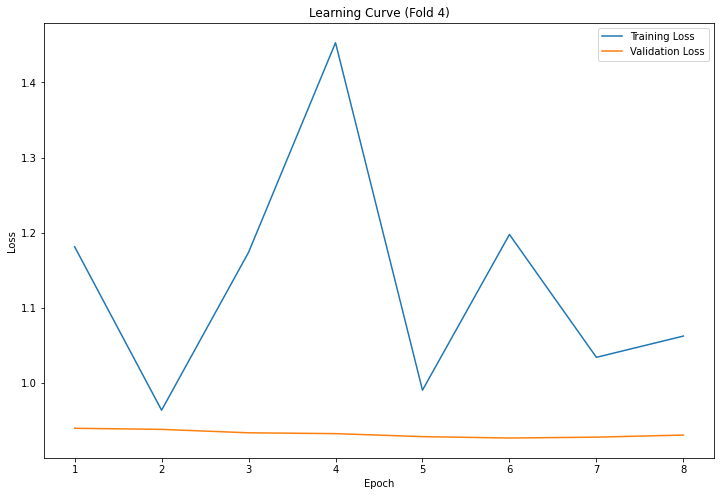

--------------DONE TRAINING MODEL FOR NetCashProvidedByUsedInInvestingActivities--------------




pytorch_model.bin:   0%|          | 0.00/439M [00:00<?, ?B/s]

In [31]:
# Define variables
batch_size = 16
epochs=40
initial_lr=2e-5
eps=1e-8
patience=3
cv=10
# Name metric
file = files[0]
metric_name = file.split('.')[0].split('_')[0]

print(f"--------------START TRAINING MODEL FOR {metric_name}--------------")

# Read csv file
df = pd.read_csv(path + file)

# Load model and tokenizer
model, tokenizer = finbert_regressor()
model.to(device)

# Scale data
scaler = StandardScaler()
df['target'] = scaler.fit_transform(df['target'].values.reshape(-1, 1))

# Prepare dataset
dataset = prepare_labeled_datasets(tokenizer, model, 300, df['text'].values.tolist(), df['target'].values.tolist()) 

# Train model
best_model_overall, best_val_loss_overall, best_fold_overall, all_train_losses, all_val_losses, training_stats  = train_finbert_regressor(model, tokenizer, dataset, 
                                                                                           epochs=epochs, initial_lr=initial_lr, 
                                                                                           eps=eps, cv=cv)


# Present results from the best model
print("Results from the best model")
print(f"Fold with best validation RSE: {best_fold_overall}")
print("Best validation RSE: {0:.2f}".format(best_val_loss_overall)) 

plot_learning_curve(training_stats,best_fold_overall)

print(f"--------------DONE TRAINING MODEL FOR {metric_name}--------------")
print("\n")

# Save models
# Check if model exists
if best_model_overall is None:
   print("No model available")
else:
   # Save models
   hub_path = 'lenguyen/' + 'distilbert_' + metric_name  
   model.push_to_hub(hub_path)
   tokenizer.push_to_hub(hub_path)
   
   # Save scaler locally
   joblib.dump(scaler, f'../models/distilbert_data/{metric_name}_scaler.pkl')


In [30]:
hub_path

'lenguyen/distilbert_NetCashProvidedByUsedInInvestingActivities'

--------------START TRAINING MODEL FOR NetCashProvidedByUsedInInvestingActivities--------------


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at yiyanghkust/finbert-pretrain and are newly initialized: ['transformer.layer.11.output_layer_norm.weight', 'transformer.layer.9.attention.k_lin.weight', 'transformer.layer.0.attention.v_lin.bias', 'transformer.layer.2.output_layer_norm.bias', 'transformer.layer.0.ffn.lin2.weight', 'transformer.layer.7.attention.q_lin.weight', 'classifier.bias', 'transformer.layer.4.ffn.lin1.weight', 'transformer.layer.4.attention.q_lin.weight', 'transformer.layer.0.sa_layer_norm.bias', 'transformer.layer.6.ffn.lin1.weight', 'transformer.layer.7.ffn.lin1.bias', 'transformer.layer.9.output_layer_norm.weight', 'transformer.layer.8.attention.out_lin.bias', 'transformer.layer.3.attention.out_lin.bias', 'transformer.layer.2.output_layer_norm.weight', 'transformer.layer.6.attention.out_lin.bias', 'transformer.layer.5.attention.k_lin.bias', 'transformer.layer.1.attention.out_lin.weight', 'transformer.layer.2.ff

Fold 1


  8%|▊         | 3/40 [00:01<00:24,  1.53it/s]


Early stopping at epoch 4 in fold 1
Fold 1 - Best Validation Loss: 3.3943045139312744 at Epoch: 1
Fold 2


  8%|▊         | 3/40 [00:02<00:25,  1.47it/s]


Early stopping at epoch 4 in fold 2
Fold 2 - Best Validation Loss: 1.6606274843215942 at Epoch: 1
Fold 3


  8%|▊         | 3/40 [00:02<00:25,  1.48it/s]


Early stopping at epoch 4 in fold 3
Fold 3 - Best Validation Loss: 169.8001251220703 at Epoch: 1
Fold 4


  8%|▊         | 3/40 [00:02<00:25,  1.46it/s]


Early stopping at epoch 4 in fold 4
Fold 4 - Best Validation Loss: 2.50692081451416 at Epoch: 1
Fold 5


  8%|▊         | 3/40 [00:02<00:25,  1.47it/s]


Early stopping at epoch 4 in fold 5
Fold 5 - Best Validation Loss: 3.5066232681274414 at Epoch: 1
Fold 6


  8%|▊         | 3/40 [00:02<00:25,  1.47it/s]


Early stopping at epoch 4 in fold 6
Fold 6 - Best Validation Loss: 4.302547931671143 at Epoch: 1
Fold 7


  8%|▊         | 3/40 [00:02<00:25,  1.47it/s]


Early stopping at epoch 4 in fold 7
Fold 7 - Best Validation Loss: 4.262661457061768 at Epoch: 1
Fold 8


  8%|▊         | 3/40 [00:02<00:25,  1.46it/s]


Early stopping at epoch 4 in fold 8
Fold 8 - Best Validation Loss: 3.962122917175293 at Epoch: 1
Fold 9


  8%|▊         | 3/40 [00:02<00:25,  1.46it/s]


Early stopping at epoch 4 in fold 9
Fold 9 - Best Validation Loss: 2.1842150688171387 at Epoch: 1
Fold 10


  8%|▊         | 3/40 [00:02<00:25,  1.48it/s]

Early stopping at epoch 4 in fold 10
Fold 10 - Best Validation Loss: 3.2420859336853027 at Epoch: 1
Results from the best model
Fold with best validation RSE: 2
Best validation RSE: 1.66


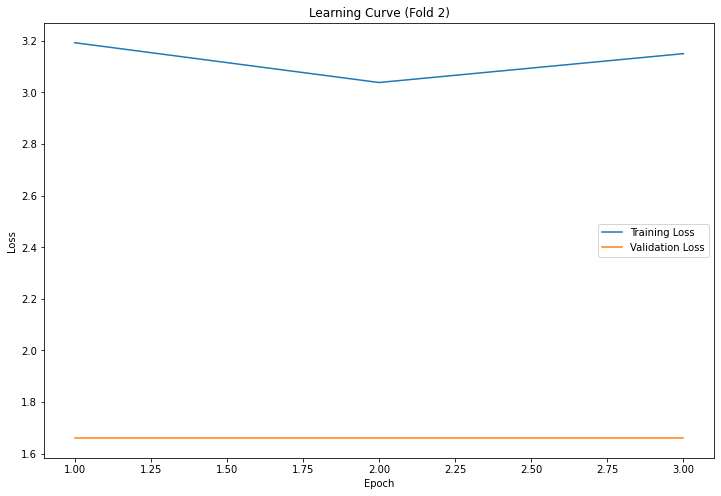

--------------DONE TRAINING MODEL FOR NetCashProvidedByUsedInInvestingActivities--------------




In [33]:
# Define variables
batch_size = 16
epochs=40
initial_lr=2e-5
eps=1e-8
patience=3
cv=10
# Name metric
file = files[0]
metric_name = file.split('.')[0].split('_')[0]

print(f"--------------START TRAINING MODEL FOR {metric_name}--------------")

# Read csv file
df = pd.read_csv(path + file)

# Load model and tokenizer
model, tokenizer = finbert_regressor()
model.to(device)

# Prepare dataset
dataset = prepare_labeled_datasets(tokenizer, model, 300, df['text'].values.tolist(), df['target'].values.tolist()) 

# Train model
best_model_overall, best_val_loss_overall, best_fold_overall, all_train_losses, all_val_losses, training_stats  = train_finbert_regressor(model, tokenizer, dataset, 
                                                                                           epochs=epochs, initial_lr=initial_lr, 
                                                                                           eps=eps, cv=cv)


# Present results from the best model
print("Results from the best model")
print(f"Fold with best validation RSE: {best_fold_overall}")
print("Best validation RSE: {0:.2f}".format(best_val_loss_overall)) 

plot_learning_curve(training_stats,best_fold_overall)
print(f"--------------DONE TRAINING MODEL FOR {metric_name}--------------")
print("\n")

#### EBIT - DistilBERT

--------------START TRAINING MODEL FOR EBIT--------------


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at yiyanghkust/finbert-pretrain and are newly initialized: ['transformer.layer.3.ffn.lin2.weight', 'transformer.layer.4.attention.q_lin.weight', 'transformer.layer.1.attention.out_lin.bias', 'transformer.layer.10.sa_layer_norm.weight', 'transformer.layer.5.sa_layer_norm.bias', 'transformer.layer.8.attention.q_lin.bias', 'transformer.layer.3.output_layer_norm.weight', 'transformer.layer.5.attention.out_lin.bias', 'transformer.layer.5.ffn.lin2.bias', 'transformer.layer.9.sa_layer_norm.weight', 'transformer.layer.11.attention.q_lin.weight', 'transformer.layer.7.sa_layer_norm.bias', 'transformer.layer.10.output_layer_norm.bias', 'transformer.layer.8.attention.q_lin.weight', 'pre_classifier.weight', 'transformer.layer.9.ffn.lin2.bias', 'classifier.weight', 'transformer.layer.1.ffn.lin1.bias', 'transformer.layer.4.attention.v_lin.weight', 'transformer.layer.5.ffn.lin1.bias', 'transformer.layer.

Fold 1


 10%|█         | 4/40 [00:14<02:11,  3.66s/it]


Early stopping at epoch 5 in fold 1
Fold 1 - Best Validation Loss: 1.2825950980186462 at Epoch: 2
Fold 2


  8%|▊         | 3/40 [00:11<02:24,  3.90s/it]


Early stopping at epoch 4 in fold 2
Fold 2 - Best Validation Loss: 1.0217446982860565 at Epoch: 1
Fold 3


 18%|█▊        | 7/40 [00:23<01:50,  3.36s/it]


Early stopping at epoch 8 in fold 3
Fold 3 - Best Validation Loss: 1.5342008471488953 at Epoch: 5
Fold 4


  8%|▊         | 3/40 [00:11<02:26,  3.95s/it]


Early stopping at epoch 4 in fold 4
Fold 4 - Best Validation Loss: 1.0814454555511475 at Epoch: 1
Fold 5


 18%|█▊        | 7/40 [00:23<01:51,  3.38s/it]


Early stopping at epoch 8 in fold 5
Fold 5 - Best Validation Loss: 3.4022422432899475 at Epoch: 5
Fold 6


  8%|▊         | 3/40 [00:11<02:26,  3.95s/it]


Early stopping at epoch 4 in fold 6
Fold 6 - Best Validation Loss: 1.18993479013443 at Epoch: 1
Fold 7


 10%|█         | 4/40 [00:14<02:13,  3.71s/it]


Early stopping at epoch 5 in fold 7
Fold 7 - Best Validation Loss: 81.8041153550148 at Epoch: 2
Fold 8


 15%|█▌        | 6/40 [00:20<01:57,  3.46s/it]


Early stopping at epoch 7 in fold 8
Fold 8 - Best Validation Loss: 455.7209640145302 at Epoch: 4
Fold 9


  8%|▊         | 3/40 [00:11<02:26,  3.95s/it]


Early stopping at epoch 4 in fold 9
Fold 9 - Best Validation Loss: 2573.8107835650444 at Epoch: 1
Fold 10


 20%|██        | 8/40 [00:26<01:46,  3.33s/it]

Early stopping at epoch 9 in fold 10
Fold 10 - Best Validation Loss: 12.022425413131714 at Epoch: 6
Results from the best model
Fold with best validation RSE: 2
Best validation RSE: 1.02


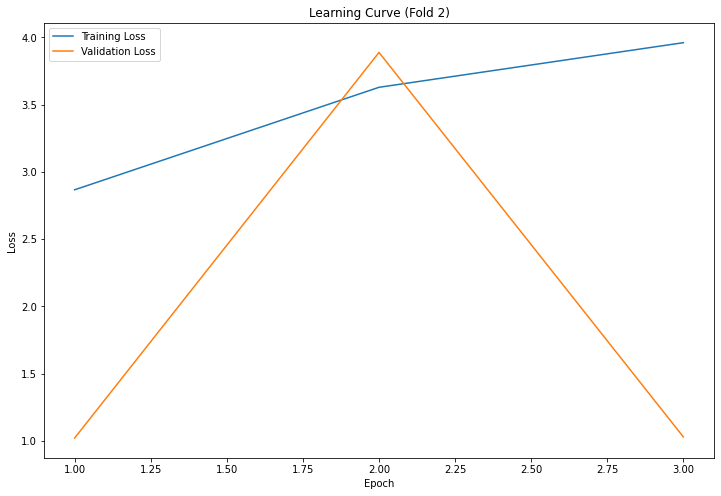

--------------DONE TRAINING MODEL FOR EBIT--------------




pytorch_model.bin:   0%|          | 0.00/439M [00:00<?, ?B/s]

In [32]:
# Define variables
batch_size = 16
epochs=40
initial_lr=2e-5
eps=1e-8
patience=5
cv=10
# Name metric
file = files[1]
metric_name = file.split('.')[0].split('_')[0]

print(f"--------------START TRAINING MODEL FOR {metric_name}--------------")

# Read csv file
df = pd.read_csv(path + file)

# Load model and tokenizer
model, tokenizer = finbert_regressor()
model.to(device)

# Scale data
scaler = StandardScaler()
df['target'] = scaler.fit_transform(df['target'].values.reshape(-1, 1))

# Prepare dataset
dataset = prepare_labeled_datasets(tokenizer, model, 300, df['text'].values.tolist(), df['target'].values.tolist()) 

# Train model
best_model_overall, best_val_loss_overall, best_fold_overall, all_train_losses, all_val_losses, training_stats  = train_finbert_regressor(model, tokenizer, dataset, 
                                                                                           epochs=epochs, initial_lr=initial_lr, 
                                                                                           eps=eps, cv=cv)




# Save models
# Check if model exists
if best_model_overall is None:
   print("No model available")
else:
   # Present results from the best model
   print("Results from the best model")
   print(f"Fold with best validation RSE: {best_fold_overall}")
   print("Best validation RSE: {0:.2f}".format(best_val_loss_overall)) 

   plot_learning_curve(training_stats,best_fold_overall)
   print(f"--------------DONE TRAINING MODEL FOR {metric_name}--------------")
   print("\n")
   # Save models
   hub_path = 'lenguyen/' + 'distilbert_' + metric_name  
   model.push_to_hub(hub_path)
   tokenizer.push_to_hub(hub_path)
   
   # Save scaler locally
   joblib.dump(scaler, f'../models/distilbert_data/{metric_name}_scaler.pkl')

--------------START TRAINING MODEL FOR EBIT--------------


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at yiyanghkust/finbert-pretrain and are newly initialized: ['transformer.layer.11.output_layer_norm.weight', 'transformer.layer.9.attention.k_lin.weight', 'transformer.layer.0.attention.v_lin.bias', 'transformer.layer.2.output_layer_norm.bias', 'transformer.layer.0.ffn.lin2.weight', 'transformer.layer.7.attention.q_lin.weight', 'classifier.bias', 'transformer.layer.4.ffn.lin1.weight', 'transformer.layer.4.attention.q_lin.weight', 'transformer.layer.0.sa_layer_norm.bias', 'transformer.layer.6.ffn.lin1.weight', 'transformer.layer.7.ffn.lin1.bias', 'transformer.layer.9.output_layer_norm.weight', 'transformer.layer.8.attention.out_lin.bias', 'transformer.layer.3.attention.out_lin.bias', 'transformer.layer.2.output_layer_norm.weight', 'transformer.layer.6.attention.out_lin.bias', 'transformer.layer.5.attention.k_lin.bias', 'transformer.layer.1.attention.out_lin.weight', 'transformer.layer.2.ff

Fold 1


  8%|▊         | 3/40 [00:11<02:23,  3.88s/it]


Early stopping at epoch 4 in fold 1
Fold 1 - Best Validation Loss: 6.922783672809601 at Epoch: 1
Fold 2


  8%|▊         | 3/40 [00:11<02:22,  3.86s/it]


Early stopping at epoch 4 in fold 2
Fold 2 - Best Validation Loss: 1.6814630627632141 at Epoch: 1
Fold 3


  8%|▊         | 3/40 [00:11<02:22,  3.86s/it]


Early stopping at epoch 4 in fold 3
Fold 3 - Best Validation Loss: 4.338296055793762 at Epoch: 1
Fold 4


  8%|▊         | 3/40 [00:11<02:23,  3.87s/it]


Early stopping at epoch 4 in fold 4
Fold 4 - Best Validation Loss: 9.854723572731018 at Epoch: 1
Fold 5


  8%|▊         | 3/40 [00:11<02:23,  3.87s/it]


Early stopping at epoch 4 in fold 5
Fold 5 - Best Validation Loss: 2.8608230352401733 at Epoch: 1
Fold 6


  8%|▊         | 3/40 [00:11<02:23,  3.88s/it]


Early stopping at epoch 4 in fold 6
Fold 6 - Best Validation Loss: 3.681907296180725 at Epoch: 1
Fold 7


  8%|▊         | 3/40 [00:11<02:23,  3.87s/it]


Early stopping at epoch 4 in fold 7
Fold 7 - Best Validation Loss: 38.01433193683624 at Epoch: 1
Fold 8


  8%|▊         | 3/40 [00:11<02:23,  3.87s/it]


Early stopping at epoch 4 in fold 8
Fold 8 - Best Validation Loss: 3.0150212049484253 at Epoch: 1
Fold 9


  8%|▊         | 3/40 [00:11<02:22,  3.86s/it]


Early stopping at epoch 4 in fold 9
Fold 9 - Best Validation Loss: 161.31616628170013 at Epoch: 1
Fold 10


  8%|▊         | 3/40 [00:11<02:23,  3.87s/it]

Early stopping at epoch 4 in fold 10
Fold 10 - Best Validation Loss: 21.35002088546753 at Epoch: 1
Results from the best model
Fold with best validation RSE: 2
Best validation RSE: 1.68


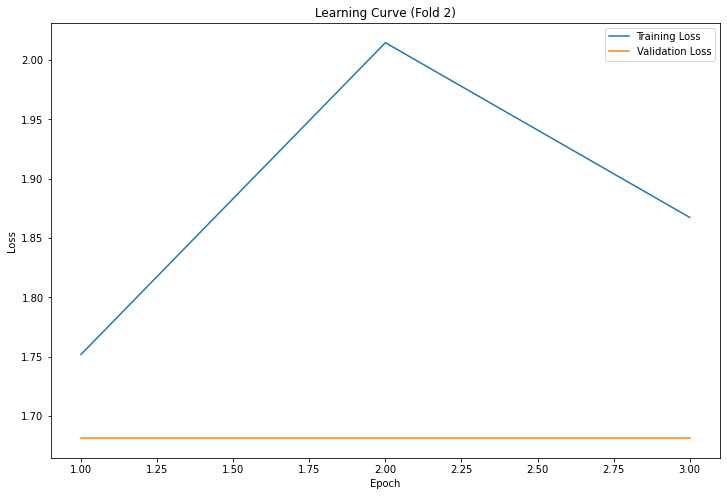

--------------DONE TRAINING MODEL FOR EBIT--------------




In [34]:
# Define variables
batch_size = 16
epochs=40
initial_lr=2e-5
eps=1e-8
patience=5
cv=10
# Name metric
file = files[1]
metric_name = file.split('.')[0].split('_')[0]

print(f"--------------START TRAINING MODEL FOR {metric_name}--------------")

# Read csv file
df = pd.read_csv(path + file)

# Load model and tokenizer
model, tokenizer = finbert_regressor()
model.to(device)

# Prepare dataset
dataset = prepare_labeled_datasets(tokenizer, model, 300, df['text'].values.tolist(), df['target'].values.tolist()) 

# Train model
best_model_overall, best_val_loss_overall, best_fold_overall, all_train_losses, all_val_losses, training_stats  = train_finbert_regressor(model, tokenizer, dataset, 
                                                                                           epochs=epochs, initial_lr=initial_lr, 
                                                                                           eps=eps, cv=cv)


# Present results from the best model
print("Results from the best model")
print(f"Fold with best validation RSE: {best_fold_overall}")
print("Best validation RSE: {0:.2f}".format(best_val_loss_overall)) 

plot_learning_curve(training_stats,best_fold_overall)
print(f"--------------DONE TRAINING MODEL FOR {metric_name}--------------")
print("\n")

#### NetCashProvidedByUsedInFinancingActivities - DistilBERT

In [5]:
# Define variables
batch_size = 16
epochs=40
initial_lr=2e-5
eps=1e-8
patience=5
cv=10
# Name metric
file = files[2]
metric_name = file.split('.')[0].split('_')[0]

print(f"--------------START TRAINING MODEL FOR {metric_name}--------------")

# Read csv file
df = pd.read_csv(path + file)

# Load model and tokenizer
model, tokenizer = finbert_regressor()
model.to(device)

# Scale data
scaler = StandardScaler()
df['target'] = scaler.fit_transform(df['target'].values.reshape(-1, 1))

# Prepare dataset
dataset = prepare_labeled_datasets(tokenizer, model, 300, df['text'].values.tolist(), df['target'].values.tolist()) 

# Train model
best_model_overall, best_val_loss_overall, best_fold_overall, all_train_losses, all_val_losses, training_stats  = train_finbert_regressor(model, tokenizer, dataset, 
                                                                                           epochs=epochs, initial_lr=initial_lr, 
                                                                                           eps=eps, cv=cv)



# Save models
# Check if model exists
if best_model_overall is None:
   print("No model available")
else:
   # Present results from the best model
   print("Results from the best model")
   print(f"Fold with best validation RSE: {best_fold_overall}")
   print("Best validation RSE: {0:.2f}".format(best_val_loss_overall)) 

   plot_learning_curve(training_stats,best_fold_overall)
   print(f"--------------DONE TRAINING MODEL FOR {metric_name}--------------")
   print("\n")
   # Save models
   hub_path = 'lenguyen/' + 'distilbert_' + metric_name  
   model.push_to_hub(hub_path)
   tokenizer.push_to_hub(hub_path)
   
   # Save scaler locally
   joblib.dump(scaler, f'../models/distilbert_data/{metric_name}_scaler.pkl')

--------------START TRAINING MODEL FOR NetCashProvidedByUsedInFinancingActivities--------------


NameError: name 'finbert_regressor' is not defined

In [13]:
# Define variables
batch_size = 8
epochs=40
initial_lr=0.00001
eps=1e-8
patience=3
cv=10
# Name metric
file = files[2]
metric_name = file.split('.')[0].split('_')[0]

print(f"--------------START TRAINING MODEL FOR {metric_name}--------------")

# Read csv file
df = pd.read_csv(path + file)

# Load model and tokenizer
model, tokenizer = finbert_regressor()
model.to(device)

# Prepare dataset
dataset = prepare_labeled_datasets(tokenizer, model, 300, df['text'].values.tolist(), df['target'].values.tolist()) 

# Train model
best_model_overall, best_val_loss_overall, best_fold_overall, all_train_losses, all_val_losses, training_stats  = train_finbert_regressor(model, tokenizer, dataset, 
                                                                                           epochs=epochs, initial_lr=initial_lr, 
                                                                                           eps=eps, cv=cv)


# Present results from the best model
print("Results from the best model")
print(f"Fold with best validation RSE: {best_fold_overall}")
print("Best validation RSE: {0:.2f}".format(best_val_loss_overall)) 

plot_learning_curve(training_stats,best_fold_overall)
print(f"--------------DONE TRAINING MODEL FOR {metric_name}--------------")
print("\n")

--------------START TRAINING MODEL FOR NetCashProvidedByUsedInFinancingActivities--------------


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at yiyanghkust/finbert-pretrain and are newly initialized: ['transformer.layer.4.attention.q_lin.weight', 'transformer.layer.4.attention.k_lin.bias', 'transformer.layer.3.output_layer_norm.weight', 'transformer.layer.10.attention.v_lin.weight', 'transformer.layer.3.ffn.lin1.bias', 'transformer.layer.4.output_layer_norm.bias', 'transformer.layer.8.ffn.lin2.bias', 'transformer.layer.7.attention.v_lin.bias', 'transformer.layer.11.ffn.lin1.bias', 'transformer.layer.0.attention.v_lin.bias', 'transformer.layer.6.attention.out_lin.bias', 'transformer.layer.6.ffn.lin1.weight', 'transformer.layer.0.attention.out_lin.bias', 'transformer.layer.0.ffn.lin1.weight', 'transformer.layer.7.sa_layer_norm.bias', 'transformer.layer.2.attention.v_lin.bias', 'transformer.layer.2.attention.v_lin.weight', 'transformer.layer.3.ffn.lin2.weight', 'transformer.layer.0.output_layer_norm.bias', 'transformer.layer.6.ou

Fold 1


  5%|▌         | 2/40 [00:01<00:19,  1.95it/s]


Early stopping at epoch 3 in fold 1
Fold 1 - Best Validation Loss: inf at Epoch: 0
Fold 2


  5%|▌         | 2/40 [00:00<00:18,  2.06it/s]


Early stopping at epoch 3 in fold 2
Fold 2 - Best Validation Loss: inf at Epoch: 0
Fold 3


  5%|▌         | 2/40 [00:00<00:18,  2.06it/s]


Early stopping at epoch 3 in fold 3
Fold 3 - Best Validation Loss: inf at Epoch: 0
Fold 4


  5%|▌         | 2/40 [00:00<00:18,  2.06it/s]


Early stopping at epoch 3 in fold 4
Fold 4 - Best Validation Loss: inf at Epoch: 0
Fold 5


  5%|▌         | 2/40 [00:00<00:18,  2.07it/s]


Early stopping at epoch 3 in fold 5
Fold 5 - Best Validation Loss: inf at Epoch: 0
Fold 6


  5%|▌         | 2/40 [00:00<00:18,  2.06it/s]


Early stopping at epoch 3 in fold 6
Fold 6 - Best Validation Loss: inf at Epoch: 0
Fold 7


  5%|▌         | 2/40 [00:00<00:18,  2.06it/s]


Early stopping at epoch 3 in fold 7
Fold 7 - Best Validation Loss: inf at Epoch: 0
Fold 8


  5%|▌         | 2/40 [00:00<00:18,  2.06it/s]


Early stopping at epoch 3 in fold 8
Fold 8 - Best Validation Loss: inf at Epoch: 0
Fold 9


  5%|▌         | 2/40 [00:00<00:18,  2.05it/s]


Early stopping at epoch 3 in fold 9
Fold 9 - Best Validation Loss: inf at Epoch: 0
Fold 10


  5%|▌         | 2/40 [00:00<00:18,  2.02it/s]

Early stopping at epoch 3 in fold 10
Fold 10 - Best Validation Loss: inf at Epoch: 0


AttributeError: 'NoneType' object has no attribute 'save_pretrained'

#### Revenue - DistilBERT

In [36]:
# Define variables
batch_size = 32
epochs=40
initial_lr=2e-5
eps=1e-8
patience=5
cv=10
# Name metric
file = files[3]
metric_name = file.split('.')[0].split('_')[0]

print(f"--------------START TRAINING MODEL FOR {metric_name}--------------")

# Read csv file
df = pd.read_csv(path + file)

# Load model and tokenizer
model, tokenizer = finbert_regressor()
model.to(device)

# Scale data
scaler = StandardScaler()
df['target'] = scaler.fit_transform(df['target'].values.reshape(-1, 1))

# Prepare dataset
dataset = prepare_labeled_datasets(tokenizer, model, 300, df['text'].values.tolist(), df['target'].values.tolist()) 

# Train model
best_model_overall, best_val_loss_overall, best_fold_overall, all_train_losses, all_val_losses, training_stats  = train_finbert_regressor(model, tokenizer, dataset, 
                                                                                           epochs=epochs, initial_lr=initial_lr, 
                                                                                           eps=eps, cv=cv)

# Save models
# Check if model exists
if best_model_overall is None:
   print("No model available")
else:
   # Present results from the best model
   print("Results from the best model")
   print(f"Fold with best validation RSE: {best_fold_overall}")
   print("Best validation RSE: {0:.2f}".format(best_val_loss_overall)) 

   plot_learning_curve(training_stats,best_fold_overall)
   print(f"--------------DONE TRAINING MODEL FOR {metric_name}--------------")
   print("\n")
   # Save models
   hub_path = 'lenguyen/' + 'distilbert_' + metric_name  
   model.push_to_hub(hub_path)
   tokenizer.push_to_hub(hub_path)
   
   # Save scaler locally
   joblib.dump(scaler, f'../models/distilbert_data/{metric_name}_scaler.pkl')

--------------START TRAINING MODEL FOR RevenueFromContractWithCustomerExcludingAssessedTax--------------


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at yiyanghkust/finbert-pretrain and are newly initialized: ['transformer.layer.3.ffn.lin2.weight', 'transformer.layer.4.attention.q_lin.weight', 'transformer.layer.1.attention.out_lin.bias', 'transformer.layer.10.sa_layer_norm.weight', 'transformer.layer.5.sa_layer_norm.bias', 'transformer.layer.8.attention.q_lin.bias', 'transformer.layer.3.output_layer_norm.weight', 'transformer.layer.5.attention.out_lin.bias', 'transformer.layer.5.ffn.lin2.bias', 'transformer.layer.9.sa_layer_norm.weight', 'transformer.layer.11.attention.q_lin.weight', 'transformer.layer.7.sa_layer_norm.bias', 'transformer.layer.10.output_layer_norm.bias', 'transformer.layer.8.attention.q_lin.weight', 'pre_classifier.weight', 'transformer.layer.9.ffn.lin2.bias', 'classifier.weight', 'transformer.layer.1.ffn.lin1.bias', 'transformer.layer.4.attention.v_lin.weight', 'transformer.layer.5.ffn.lin1.bias', 'transformer.layer.

Fold 1


  2%|▎         | 1/40 [02:24<1:33:41, 144.15s/it]


KeyboardInterrupt: 

--------------START TRAINING MODEL FOR RevenueFromContractWithCustomerExcludingAssessedTax--------------


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at yiyanghkust/finbert-pretrain and are newly initialized: ['transformer.layer.4.attention.q_lin.weight', 'transformer.layer.4.attention.k_lin.bias', 'transformer.layer.3.output_layer_norm.weight', 'transformer.layer.10.attention.v_lin.weight', 'transformer.layer.3.ffn.lin1.bias', 'transformer.layer.4.output_layer_norm.bias', 'transformer.layer.8.ffn.lin2.bias', 'transformer.layer.7.attention.v_lin.bias', 'transformer.layer.11.ffn.lin1.bias', 'transformer.layer.0.attention.v_lin.bias', 'transformer.layer.6.attention.out_lin.bias', 'transformer.layer.6.ffn.lin1.weight', 'transformer.layer.0.attention.out_lin.bias', 'transformer.layer.0.ffn.lin1.weight', 'transformer.layer.7.sa_layer_norm.bias', 'transformer.layer.2.attention.v_lin.bias', 'transformer.layer.2.attention.v_lin.weight', 'transformer.layer.3.ffn.lin2.weight', 'transformer.layer.0.output_layer_norm.bias', 'transformer.layer.6.ou

Fold 1


  8%|▊         | 3/40 [06:37<1:21:46, 132.62s/it]


Early stopping at epoch 4 in fold 1
Fold 1 - Best Validation Loss: 2.471904453635216 at Epoch: 1
Fold 2


  8%|▊         | 3/40 [06:37<1:21:36, 132.35s/it]


Early stopping at epoch 4 in fold 2
Fold 2 - Best Validation Loss: 2.358006253838539 at Epoch: 1
Fold 3


  8%|▊         | 3/40 [06:37<1:21:46, 132.61s/it]


Early stopping at epoch 4 in fold 3
Fold 3 - Best Validation Loss: 2.5547582298517226 at Epoch: 1
Fold 4


  8%|▊         | 3/40 [06:38<1:21:58, 132.93s/it]


Early stopping at epoch 4 in fold 4
Fold 4 - Best Validation Loss: 2.477512350678444 at Epoch: 1
Fold 5


  8%|▊         | 3/40 [06:37<1:21:41, 132.47s/it]


Early stopping at epoch 4 in fold 5
Fold 5 - Best Validation Loss: 2.546011510491371 at Epoch: 1
Fold 6


  8%|▊         | 3/40 [06:37<1:21:41, 132.48s/it]


Early stopping at epoch 4 in fold 6
Fold 6 - Best Validation Loss: 2.4271595895290377 at Epoch: 1
Fold 7


  8%|▊         | 3/40 [06:37<1:21:37, 132.36s/it]


Early stopping at epoch 4 in fold 7
Fold 7 - Best Validation Loss: 2.500996345281601 at Epoch: 1
Fold 8


  8%|▊         | 3/40 [06:37<1:21:37, 132.37s/it]


Early stopping at epoch 4 in fold 8
Fold 8 - Best Validation Loss: 2.367585062980652 at Epoch: 1
Fold 9


  8%|▊         | 3/40 [06:36<1:21:31, 132.21s/it]


Early stopping at epoch 4 in fold 9
Fold 9 - Best Validation Loss: 2.554607221484184 at Epoch: 1
Fold 10


  8%|▊         | 3/40 [06:37<1:21:40, 132.44s/it]

Early stopping at epoch 4 in fold 10
Fold 10 - Best Validation Loss: 4.762203374505043 at Epoch: 1


Results from the best model
Fold with best validation RSE: 2
Best validation RSE: 2.36


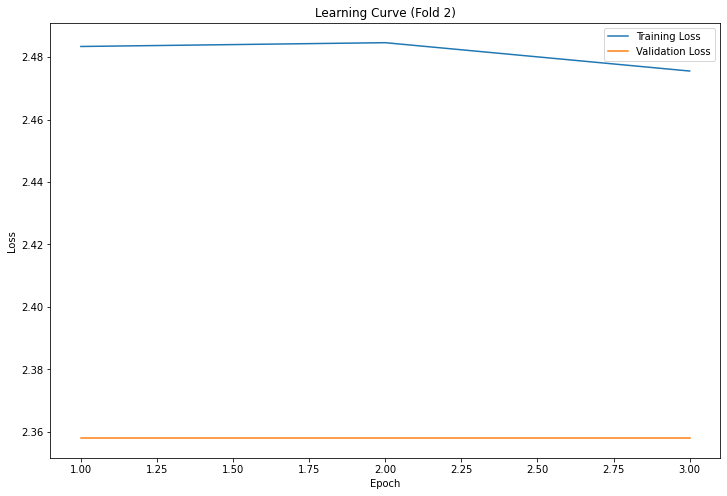

--------------DONE TRAINING MODEL FOR RevenueFromContractWithCustomerExcludingAssessedTax--------------




In [14]:
# Define variables
batch_size = 32
epochs=40
initial_lr=0.0001
eps=1e-8
patience=5
cv=10
# Name metric
file = files[3]
metric_name = file.split('.')[0].split('_')[0]

print(f"--------------START TRAINING MODEL FOR {metric_name}--------------")

# Read csv file
df = pd.read_csv(path + file)

# Load model and tokenizer
model, tokenizer = finbert_regressor()
model.to(device)

# Prepare dataset
dataset = prepare_labeled_datasets(tokenizer, model, 300, df['text'].values.tolist(), df['target'].values.tolist()) 

# Train model
best_model_overall, best_val_loss_overall, best_fold_overall, all_train_losses, all_val_losses, training_stats  = train_finbert_regressor(model, tokenizer, dataset, 
                                                                                           epochs=epochs, initial_lr=initial_lr, 
                                                                                           eps=eps, cv=cv) 

# Save models
#If folder not available, create folder
if not os.path.exists('../models/finbert-regression/distilbert_data/' + metric_name):
   os.makedirs('../models/finbert-regression/distilbert_data/' + metric_name)
# Save model to folder
best_model_overall.save_pretrained('../models/finbert-regression/distilbert_data/' + metric_name) 

# Present results from the best model
print("Results from the best model")
print(f"Fold with best validation RSE: {best_fold_overall}")
print("Best validation RSE: {0:.2f}".format(best_val_loss_overall)) 

plot_learning_curve(training_stats,best_fold_overall)
print(f"--------------DONE TRAINING MODEL FOR {metric_name}--------------")
print("\n")

#### NetIncomeLoss - DistilBERT

In [13]:
# Define variables
batch_size = 32
epochs=40
initial_lr=2e-5
eps=1e-8
patience=5
cv=10
# Name metric
file = files[4]
metric_name = file.split('.')[0].split('_')[0]

print(f"--------------START TRAINING MODEL FOR {metric_name}--------------")

# Read csv file
df = pd.read_csv(path + file)

# Load model and tokenizer
model, tokenizer = finbert_regressor()
model.to(device)

# Scale data
scaler = StandardScaler()
df['target'] = scaler.fit_transform(df['target'].values.reshape(-1, 1))

# Prepare dataset
dataset = prepare_labeled_datasets(tokenizer, model, 300, df['text'].values.tolist(), df['target'].values.tolist()) 

# Train model
best_model_overall, best_val_loss_overall, best_fold_overall, all_train_losses, all_val_losses, training_stats  = train_finbert_regressor(model, tokenizer, dataset, 
                                                                                           epochs=epochs, initial_lr=initial_lr, 
                                                                                           eps=eps, cv=cv)


# Save models
# Check if model exists
if best_model_overall is None:
   print("No model available")
else:
   # Present results from the best model
   print("Results from the best model")
   print(f"Fold with best validation RSE: {best_fold_overall}")
   print("Best validation RSE: {0:.2f}".format(best_val_loss_overall)) 

   plot_learning_curve(training_stats,best_fold_overall)
   print(f"--------------DONE TRAINING MODEL FOR {metric_name}--------------")
   print("\n")
   # Save models
   hub_path = 'lenguyen/' + 'distilbert_' + metric_name  
   model.push_to_hub(hub_path)
   tokenizer.push_to_hub(hub_path)
   
   # Save scaler locally
   joblib.dump(scaler, f'../models/distilbert_data/{metric_name}_scaler.pkl')

--------------START TRAINING MODEL FOR NetIncomeLoss--------------


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at yiyanghkust/finbert-pretrain and are newly initialized: ['transformer.layer.9.attention.k_lin.weight', 'transformer.layer.2.attention.k_lin.weight', 'transformer.layer.8.output_layer_norm.bias', 'transformer.layer.10.ffn.lin1.weight', 'transformer.layer.0.ffn.lin2.bias', 'transformer.layer.11.attention.out_lin.weight', 'embeddings.LayerNorm.bias', 'transformer.layer.0.attention.k_lin.weight', 'transformer.layer.3.output_layer_norm.weight', 'transformer.layer.7.sa_layer_norm.bias', 'transformer.layer.0.attention.q_lin.weight', 'transformer.layer.6.sa_layer_norm.bias', 'transformer.layer.7.ffn.lin2.bias', 'transformer.layer.1.attention.k_lin.weight', 'transformer.layer.1.sa_layer_norm.weight', 'transformer.layer.3.sa_layer_norm.bias', 'transformer.layer.6.attention.k_lin.bias', 'transformer.layer.9.attention.k_lin.bias', 'transformer.layer.1.attention.out_lin.bias', 'transformer.layer.10

NameError: name 'StandardScaler' is not defined

--------------START TRAINING MODEL FOR NetIncomeLoss--------------


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at yiyanghkust/finbert-pretrain and are newly initialized: ['transformer.layer.4.attention.q_lin.weight', 'transformer.layer.4.attention.k_lin.bias', 'transformer.layer.3.output_layer_norm.weight', 'transformer.layer.10.attention.v_lin.weight', 'transformer.layer.3.ffn.lin1.bias', 'transformer.layer.4.output_layer_norm.bias', 'transformer.layer.8.ffn.lin2.bias', 'transformer.layer.7.attention.v_lin.bias', 'transformer.layer.11.ffn.lin1.bias', 'transformer.layer.0.attention.v_lin.bias', 'transformer.layer.6.attention.out_lin.bias', 'transformer.layer.6.ffn.lin1.weight', 'transformer.layer.0.attention.out_lin.bias', 'transformer.layer.0.ffn.lin1.weight', 'transformer.layer.7.sa_layer_norm.bias', 'transformer.layer.2.attention.v_lin.bias', 'transformer.layer.2.attention.v_lin.weight', 'transformer.layer.3.ffn.lin2.weight', 'transformer.layer.0.output_layer_norm.bias', 'transformer.layer.6.ou

Fold 1


  0%|          | 0/40 [00:00<?, ?it/s]

100%|██████████| 40/40 [1:35:18<00:00, 142.96s/it]


Fold 1 - Best Validation Loss: 1.9301346414967586 at Epoch: 40
Fold 2


100%|██████████| 40/40 [1:35:20<00:00, 143.00s/it]


Fold 2 - Best Validation Loss: 2.071267194915236 at Epoch: 40
Fold 3


 30%|███       | 12/40 [30:57<1:12:14, 154.79s/it]


Early stopping at epoch 13 in fold 3
Fold 3 - Best Validation Loss: 2.0236763389487016 at Epoch: 10
Fold 4


  8%|▊         | 3/40 [09:31<1:57:32, 190.60s/it]


Early stopping at epoch 4 in fold 4
Fold 4 - Best Validation Loss: 1.9172080797061586 at Epoch: 1
Fold 5


  8%|▊         | 3/40 [09:31<1:57:31, 190.58s/it]


Early stopping at epoch 4 in fold 5
Fold 5 - Best Validation Loss: 1.9955988369489972 at Epoch: 1
Fold 6


  8%|▊         | 3/40 [09:36<1:58:24, 192.01s/it]


Early stopping at epoch 4 in fold 6
Fold 6 - Best Validation Loss: 2.0198692564378704 at Epoch: 1
Fold 7


  8%|▊         | 3/40 [09:32<1:57:38, 190.76s/it]


Early stopping at epoch 4 in fold 7
Fold 7 - Best Validation Loss: 2.078331391016642 at Epoch: 1
Fold 8


  8%|▊         | 3/40 [09:34<1:58:05, 191.50s/it]


Early stopping at epoch 4 in fold 8
Fold 8 - Best Validation Loss: 1.9211034000965588 at Epoch: 1
Fold 9


  8%|▊         | 3/40 [09:35<1:58:15, 191.77s/it]


Early stopping at epoch 4 in fold 9
Fold 9 - Best Validation Loss: 1.8809755894175746 at Epoch: 1
Fold 10


  8%|▊         | 3/40 [09:38<1:59:00, 192.99s/it]

Early stopping at epoch 4 in fold 10
Fold 10 - Best Validation Loss: 1.9515829169959353 at Epoch: 1


Results from the best model
Fold with best validation RSE: 9
Best validation RSE: 1.88


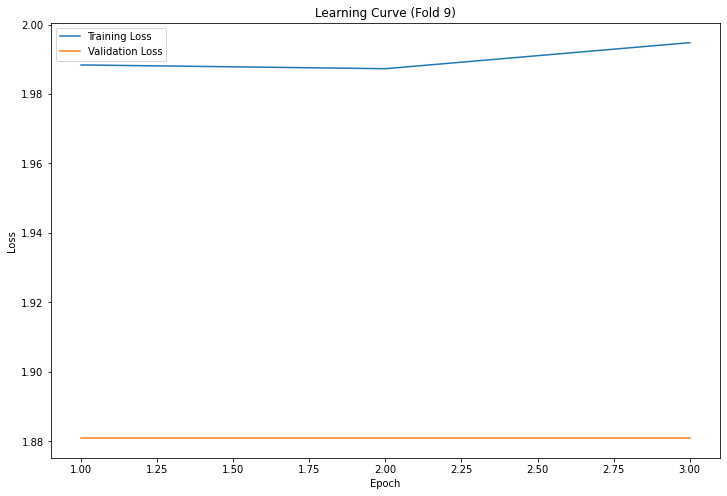

--------------DONE TRAINING MODEL FOR NetIncomeLoss--------------




In [15]:
# Define variables
batch_size = 32
epochs=40
initial_lr=0.001
eps=1e-8
patience=5
cv=10
# Name metric
file = files[4]
metric_name = file.split('.')[0].split('_')[0]

print(f"--------------START TRAINING MODEL FOR {metric_name}--------------")

# Read csv file
df = pd.read_csv(path + file)

# Load model and tokenizer
model, tokenizer = finbert_regressor()
model.to(device)

# Prepare dataset
dataset = prepare_labeled_datasets(tokenizer, model, 300, df['text'].values.tolist(), df['target'].values.tolist()) 

# Train model
best_model_overall, best_val_loss_overall, best_fold_overall, all_train_losses, all_val_losses, training_stats  = train_finbert_regressor(model, tokenizer, dataset, 
                                                                                           epochs=epochs, initial_lr=initial_lr, 
                                                                                           eps=eps, cv=cv)  

# Save models
#If folder not available, create folder
if not os.path.exists('../models/finbert-regression/distilbert_data/' + metric_name):
   os.makedirs('../models/finbert-regression/distilbert_data/' + metric_name)
# Save model to folder
best_model_overall.save_pretrained('../models/finbert-regression/distilbert_data/' + metric_name) 

# Present results from the best model
print("Results from the best model")
print(f"Fold with best validation RSE: {best_fold_overall}")
print("Best validation RSE: {0:.2f}".format(best_val_loss_overall)) 

plot_learning_curve(training_stats,best_fold_overall)
print(f"--------------DONE TRAINING MODEL FOR {metric_name}--------------")
print("\n")

#### EPS - DistilBERT

--------------START TRAINING MODEL FOR EarningsPerShareDiluted--------------


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at yiyanghkust/finbert-pretrain and are newly initialized: ['transformer.layer.3.ffn.lin2.weight', 'transformer.layer.4.attention.q_lin.weight', 'transformer.layer.1.attention.out_lin.bias', 'transformer.layer.10.sa_layer_norm.weight', 'transformer.layer.5.sa_layer_norm.bias', 'transformer.layer.8.attention.q_lin.bias', 'transformer.layer.3.output_layer_norm.weight', 'transformer.layer.5.attention.out_lin.bias', 'transformer.layer.5.ffn.lin2.bias', 'transformer.layer.9.sa_layer_norm.weight', 'transformer.layer.11.attention.q_lin.weight', 'transformer.layer.7.sa_layer_norm.bias', 'transformer.layer.10.output_layer_norm.bias', 'transformer.layer.8.attention.q_lin.weight', 'pre_classifier.weight', 'transformer.layer.9.ffn.lin2.bias', 'classifier.weight', 'transformer.layer.1.ffn.lin1.bias', 'transformer.layer.4.attention.v_lin.weight', 'transformer.layer.5.ffn.lin1.bias', 'transformer.layer.

Fold 1


 10%|█         | 4/40 [00:28<04:13,  7.04s/it]


Early stopping at epoch 5 in fold 1
Fold 1 - Best Validation Loss: 1.138563632965088 at Epoch: 2
Fold 2


 10%|█         | 4/40 [00:28<04:14,  7.08s/it]


Early stopping at epoch 5 in fold 2
Fold 2 - Best Validation Loss: 1.015421946843465 at Epoch: 2
Fold 3


100%|██████████| 40/40 [03:47<00:00,  5.68s/it]


Fold 3 - Best Validation Loss: 0.710765024026235 at Epoch: 40
Fold 4


 15%|█▌        | 6/40 [00:39<03:45,  6.64s/it]


Early stopping at epoch 7 in fold 4
Fold 4 - Best Validation Loss: 0.6283259689807892 at Epoch: 4
Fold 5


  8%|▊         | 3/40 [00:22<04:41,  7.62s/it]


Early stopping at epoch 4 in fold 5
Fold 5 - Best Validation Loss: 0.709128350019455 at Epoch: 1
Fold 6


 12%|█▎        | 5/40 [00:34<03:59,  6.84s/it]


Early stopping at epoch 6 in fold 6
Fold 6 - Best Validation Loss: 1.0927207966645558 at Epoch: 3
Fold 7


 25%|██▌       | 10/40 [01:02<03:07,  6.27s/it]


Early stopping at epoch 11 in fold 7
Fold 7 - Best Validation Loss: 0.7900467912356058 at Epoch: 8
Fold 8


 40%|████      | 16/40 [01:36<02:25,  6.06s/it]


Early stopping at epoch 17 in fold 8
Fold 8 - Best Validation Loss: 2.588697373867035 at Epoch: 14
Fold 9


  8%|▊         | 3/40 [00:22<04:41,  7.61s/it]


Early stopping at epoch 4 in fold 9
Fold 9 - Best Validation Loss: 6.461831569671631 at Epoch: 1
Fold 10


  8%|▊         | 3/40 [00:22<04:41,  7.61s/it]

Early stopping at epoch 4 in fold 10
Fold 10 - Best Validation Loss: 3.163638472557068 at Epoch: 1
Results from the best model
Fold with best validation RSE: 4
Best validation RSE: 0.63


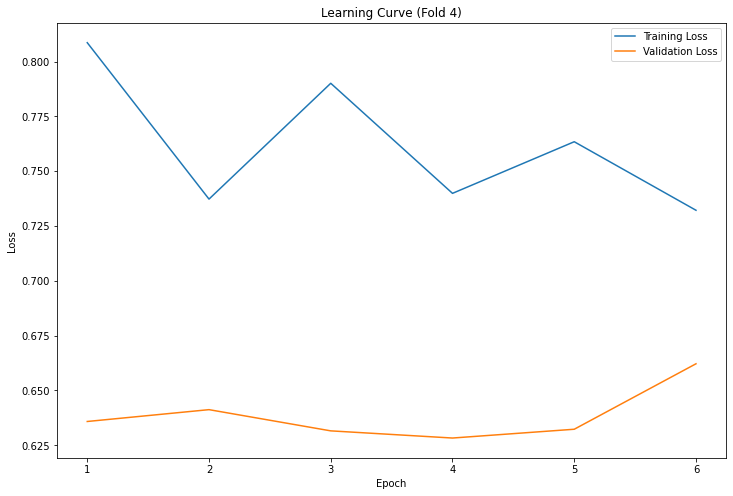

--------------DONE TRAINING MODEL FOR EarningsPerShareDiluted--------------




NameError: name 'scaler' is not defined

In [ ]:
# Define variables
batch_size = 32
epochs=40
initial_lr=2e-5
eps=1e-8
patience=5
cv=10
# Name metric
file = files[5]
metric_name = file.split('.')[0].split('_')[0]

print(f"--------------START TRAINING MODEL FOR {metric_name}--------------")

# Read csv file
df = pd.read_csv(path + file)

# Load model and tokenizer
model, tokenizer = finbert_regressor()
model.to(device)

# Scale data
scaler = StandardScaler()
df['target'] = scaler.fit_transform(df['target'].values.reshape(-1, 1))

# Prepare dataset
dataset = prepare_labeled_datasets(tokenizer, model, 300, df['text'].values.tolist(), df['target'].values.tolist()) 

# Train model
best_model_overall, best_val_loss_overall, best_fold_overall, all_train_losses, all_val_losses, training_stats  = train_finbert_regressor(model, tokenizer, dataset, 
                                                                                           epochs=epochs, initial_lr=initial_lr, 
                                                                                           eps=eps, cv=cv)





# Save models
# Check if model exists
if best_model_overall is None:
   print("No model available")
else:
   # Present results from the best model
   print("Results from the best model")
   print(f"Fold with best validation RSE: {best_fold_overall}")
   print("Best validation RSE: {0:.2f}".format(best_val_loss_overall)) 

   plot_learning_curve(training_stats,best_fold_overall)
   print(f"--------------DONE TRAINING MODEL FOR {metric_name}--------------")
   print("\n")
   # Save models
   hub_path = 'lenguyen/' + 'distilbert_' + metric_name  
   model.push_to_hub(hub_path)
   tokenizer.push_to_hub(hub_path)
   
   # Save scaler locally
   joblib.dump(scaler, f'../models/distilbert_data/{metric_name}_scaler.pkl')

--------------START TRAINING MODEL FOR EarningsPerShareDiluted--------------


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at yiyanghkust/finbert-pretrain and are newly initialized: ['transformer.layer.4.attention.q_lin.weight', 'transformer.layer.4.attention.k_lin.bias', 'transformer.layer.3.output_layer_norm.weight', 'transformer.layer.10.attention.v_lin.weight', 'transformer.layer.3.ffn.lin1.bias', 'transformer.layer.4.output_layer_norm.bias', 'transformer.layer.8.ffn.lin2.bias', 'transformer.layer.7.attention.v_lin.bias', 'transformer.layer.11.ffn.lin1.bias', 'transformer.layer.0.attention.v_lin.bias', 'transformer.layer.6.attention.out_lin.bias', 'transformer.layer.6.ffn.lin1.weight', 'transformer.layer.0.attention.out_lin.bias', 'transformer.layer.0.ffn.lin1.weight', 'transformer.layer.7.sa_layer_norm.bias', 'transformer.layer.2.attention.v_lin.bias', 'transformer.layer.2.attention.v_lin.weight', 'transformer.layer.3.ffn.lin2.weight', 'transformer.layer.0.output_layer_norm.bias', 'transformer.layer.6.ou

Fold 1


 12%|█▎        | 5/40 [00:33<03:54,  6.69s/it]


Early stopping at epoch 6 in fold 1
Fold 1 - Best Validation Loss: 1.0332732200622559 at Epoch: 3
Fold 2


 18%|█▊        | 7/40 [00:44<03:30,  6.38s/it]


Early stopping at epoch 8 in fold 2
Fold 2 - Best Validation Loss: 1.4027671416600545 at Epoch: 5
Fold 3


 10%|█         | 4/40 [00:27<04:11,  6.98s/it]


Early stopping at epoch 5 in fold 3
Fold 3 - Best Validation Loss: 1.0506080389022827 at Epoch: 2
Fold 4


 15%|█▌        | 6/40 [00:39<03:42,  6.54s/it]


Early stopping at epoch 7 in fold 4
Fold 4 - Best Validation Loss: 1.1050763527552288 at Epoch: 4
Fold 5


  8%|▊         | 3/40 [00:22<04:36,  7.48s/it]


Early stopping at epoch 4 in fold 5
Fold 5 - Best Validation Loss: 3.6547878185908 at Epoch: 1
Fold 6


 12%|█▎        | 5/40 [00:33<03:55,  6.72s/it]


Early stopping at epoch 6 in fold 6
Fold 6 - Best Validation Loss: 1.0177386204401653 at Epoch: 3
Fold 7


 10%|█         | 4/40 [00:27<04:11,  6.99s/it]


Early stopping at epoch 5 in fold 7
Fold 7 - Best Validation Loss: 1.6436564922332764 at Epoch: 2
Fold 8


  8%|▊         | 3/40 [00:22<04:35,  7.46s/it]


Early stopping at epoch 4 in fold 8
Fold 8 - Best Validation Loss: 3.73425030708313 at Epoch: 1
Fold 9


 12%|█▎        | 5/40 [00:33<03:54,  6.71s/it]


Early stopping at epoch 6 in fold 9
Fold 9 - Best Validation Loss: 1.56431245803833 at Epoch: 3
Fold 10


 25%|██▌       | 10/40 [01:01<03:03,  6.12s/it]

Early stopping at epoch 11 in fold 10
Fold 10 - Best Validation Loss: 1.2212350765864055 at Epoch: 8


Results from the best model
Fold with best validation RSE: 6
Best validation RSE: 1.02


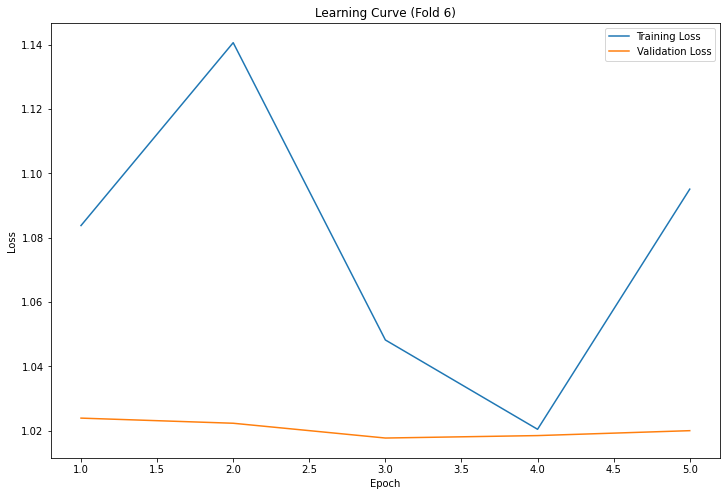

--------------DONE TRAINING MODEL FOR EarningsPerShareDiluted--------------




In [16]:
# Define variables
batch_size = 32
epochs=40
initial_lr=0.001
eps=1e-8
patience=5
cv=10
# Name metric
file = files[5]
metric_name = file.split('.')[0].split('_')[0]

print(f"--------------START TRAINING MODEL FOR {metric_name}--------------")

# Read csv file
df = pd.read_csv(path + file)

# Load model and tokenizer
model, tokenizer = finbert_regressor()
model.to(device)

# Prepare dataset
dataset = prepare_labeled_datasets(tokenizer, model, 300, df['text'].values.tolist(), df['target'].values.tolist()) 

# Train model
best_model_overall, best_val_loss_overall, best_fold_overall, all_train_losses, all_val_losses, training_stats  = train_finbert_regressor(model, tokenizer, dataset, 
                                                                                           epochs=epochs, initial_lr=initial_lr, 
                                                                                           eps=eps, cv=cv)  

# Save models
#If folder not available, create folder
if not os.path.exists('../models/finbert-regression/distilbert_data/' + metric_name):
   os.makedirs('../models/finbert-regression/distilbert_data/' + metric_name)
# Save model to folder
best_model_overall.save_pretrained('../models/finbert-regression/distilbert_data/' + metric_name) 

# Present results from the best model
print("Results from the best model")
print(f"Fold with best validation RSE: {best_fold_overall}")
print("Best validation RSE: {0:.2f}".format(best_val_loss_overall)) 

plot_learning_curve(training_stats,best_fold_overall)
print(f"--------------DONE TRAINING MODEL FOR {metric_name}--------------")
print("\n")

### CV on all FinBERT data

--------------START TRAINING MODEL FOR NetCashProvidedByUsedInInvestingActivities--------------


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at yiyanghkust/finbert-pretrain and are newly initialized: ['transformer.layer.9.attention.k_lin.weight', 'transformer.layer.2.attention.k_lin.weight', 'transformer.layer.8.output_layer_norm.bias', 'transformer.layer.10.ffn.lin1.weight', 'transformer.layer.0.ffn.lin2.bias', 'transformer.layer.11.attention.out_lin.weight', 'embeddings.LayerNorm.bias', 'transformer.layer.0.attention.k_lin.weight', 'transformer.layer.3.output_layer_norm.weight', 'transformer.layer.7.sa_layer_norm.bias', 'transformer.layer.0.attention.q_lin.weight', 'transformer.layer.6.sa_layer_norm.bias', 'transformer.layer.7.ffn.lin2.bias', 'transformer.layer.1.attention.k_lin.weight', 'transformer.layer.1.sa_layer_norm.weight', 'transformer.layer.3.sa_layer_norm.bias', 'transformer.layer.6.attention.k_lin.bias', 'transformer.layer.9.attention.k_lin.bias', 'transformer.layer.1.attention.out_lin.bias', 'transformer.layer.10

Results from the best model
Fold with best validation RSE: 10
Best validation RSE: 0.99


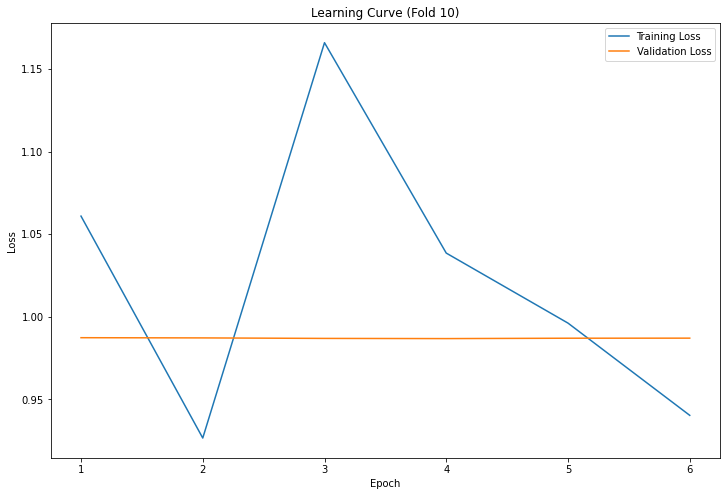

--------------DONE TRAINING MODEL FOR NetCashProvidedByUsedInInvestingActivities--------------




pytorch_model.bin:   0%|          | 0.00/439M [00:00<?, ?B/s]

--------------START TRAINING MODEL FOR EBIT--------------


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at yiyanghkust/finbert-pretrain and are newly initialized: ['transformer.layer.9.attention.k_lin.weight', 'transformer.layer.2.attention.k_lin.weight', 'transformer.layer.8.output_layer_norm.bias', 'transformer.layer.10.ffn.lin1.weight', 'transformer.layer.0.ffn.lin2.bias', 'transformer.layer.11.attention.out_lin.weight', 'embeddings.LayerNorm.bias', 'transformer.layer.0.attention.k_lin.weight', 'transformer.layer.3.output_layer_norm.weight', 'transformer.layer.7.sa_layer_norm.bias', 'transformer.layer.0.attention.q_lin.weight', 'transformer.layer.6.sa_layer_norm.bias', 'transformer.layer.7.ffn.lin2.bias', 'transformer.layer.1.attention.k_lin.weight', 'transformer.layer.1.sa_layer_norm.weight', 'transformer.layer.3.sa_layer_norm.bias', 'transformer.layer.6.attention.k_lin.bias', 'transformer.layer.9.attention.k_lin.bias', 'transformer.layer.1.attention.out_lin.bias', 'transformer.layer.10

Results from the best model
Fold with best validation RSE: 3
Best validation RSE: 1.01


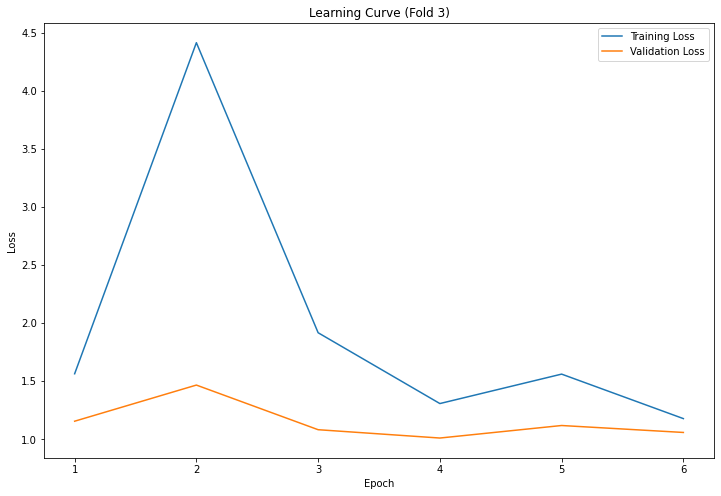

--------------DONE TRAINING MODEL FOR EBIT--------------




pytorch_model.bin:   0%|          | 0.00/439M [00:00<?, ?B/s]

--------------START TRAINING MODEL FOR NetCashProvidedByUsedInFinancingActivities--------------


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at yiyanghkust/finbert-pretrain and are newly initialized: ['transformer.layer.9.attention.k_lin.weight', 'transformer.layer.2.attention.k_lin.weight', 'transformer.layer.8.output_layer_norm.bias', 'transformer.layer.10.ffn.lin1.weight', 'transformer.layer.0.ffn.lin2.bias', 'transformer.layer.11.attention.out_lin.weight', 'embeddings.LayerNorm.bias', 'transformer.layer.0.attention.k_lin.weight', 'transformer.layer.3.output_layer_norm.weight', 'transformer.layer.7.sa_layer_norm.bias', 'transformer.layer.0.attention.q_lin.weight', 'transformer.layer.6.sa_layer_norm.bias', 'transformer.layer.7.ffn.lin2.bias', 'transformer.layer.1.attention.k_lin.weight', 'transformer.layer.1.sa_layer_norm.weight', 'transformer.layer.3.sa_layer_norm.bias', 'transformer.layer.6.attention.k_lin.bias', 'transformer.layer.9.attention.k_lin.bias', 'transformer.layer.1.attention.out_lin.bias', 'transformer.layer.10

Results from the best model
Fold with best validation RSE: 3
Best validation RSE: 0.99


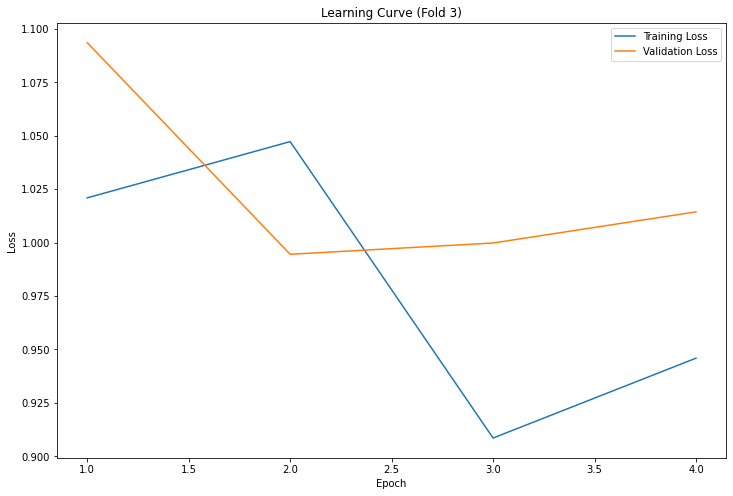

--------------DONE TRAINING MODEL FOR NetCashProvidedByUsedInFinancingActivities--------------




pytorch_model.bin:   0%|          | 0.00/439M [00:00<?, ?B/s]

--------------START TRAINING MODEL FOR RevenueFromContractWithCustomerExcludingAssessedTax--------------


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at yiyanghkust/finbert-pretrain and are newly initialized: ['transformer.layer.9.attention.k_lin.weight', 'transformer.layer.2.attention.k_lin.weight', 'transformer.layer.8.output_layer_norm.bias', 'transformer.layer.10.ffn.lin1.weight', 'transformer.layer.0.ffn.lin2.bias', 'transformer.layer.11.attention.out_lin.weight', 'embeddings.LayerNorm.bias', 'transformer.layer.0.attention.k_lin.weight', 'transformer.layer.3.output_layer_norm.weight', 'transformer.layer.7.sa_layer_norm.bias', 'transformer.layer.0.attention.q_lin.weight', 'transformer.layer.6.sa_layer_norm.bias', 'transformer.layer.7.ffn.lin2.bias', 'transformer.layer.1.attention.k_lin.weight', 'transformer.layer.1.sa_layer_norm.weight', 'transformer.layer.3.sa_layer_norm.bias', 'transformer.layer.6.attention.k_lin.bias', 'transformer.layer.9.attention.k_lin.bias', 'transformer.layer.1.attention.out_lin.bias', 'transformer.layer.10

Results from the best model
Fold with best validation RSE: 5
Best validation RSE: 0.23


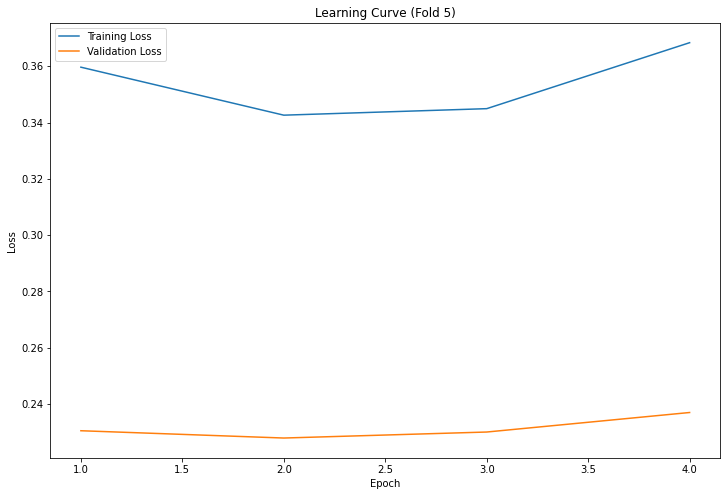

--------------DONE TRAINING MODEL FOR RevenueFromContractWithCustomerExcludingAssessedTax--------------




pytorch_model.bin:   0%|          | 0.00/439M [00:00<?, ?B/s]

--------------START TRAINING MODEL FOR NetIncomeLoss--------------


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at yiyanghkust/finbert-pretrain and are newly initialized: ['transformer.layer.9.attention.k_lin.weight', 'transformer.layer.2.attention.k_lin.weight', 'transformer.layer.8.output_layer_norm.bias', 'transformer.layer.10.ffn.lin1.weight', 'transformer.layer.0.ffn.lin2.bias', 'transformer.layer.11.attention.out_lin.weight', 'embeddings.LayerNorm.bias', 'transformer.layer.0.attention.k_lin.weight', 'transformer.layer.3.output_layer_norm.weight', 'transformer.layer.7.sa_layer_norm.bias', 'transformer.layer.0.attention.q_lin.weight', 'transformer.layer.6.sa_layer_norm.bias', 'transformer.layer.7.ffn.lin2.bias', 'transformer.layer.1.attention.k_lin.weight', 'transformer.layer.1.sa_layer_norm.weight', 'transformer.layer.3.sa_layer_norm.bias', 'transformer.layer.6.attention.k_lin.bias', 'transformer.layer.9.attention.k_lin.bias', 'transformer.layer.1.attention.out_lin.bias', 'transformer.layer.10

Results from the best model
Fold with best validation RSE: 5
Best validation RSE: 0.46


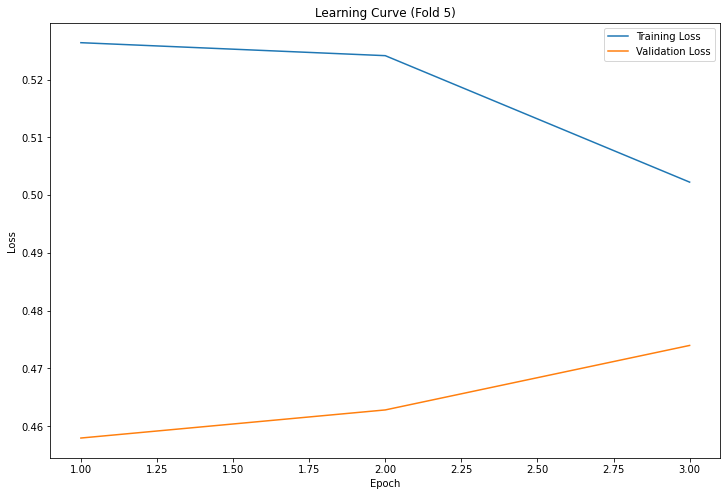

--------------DONE TRAINING MODEL FOR NetIncomeLoss--------------




pytorch_model.bin:   0%|          | 0.00/439M [00:00<?, ?B/s]

--------------START TRAINING MODEL FOR EarningsPerShareDiluted--------------


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at yiyanghkust/finbert-pretrain and are newly initialized: ['transformer.layer.9.attention.k_lin.weight', 'transformer.layer.2.attention.k_lin.weight', 'transformer.layer.8.output_layer_norm.bias', 'transformer.layer.10.ffn.lin1.weight', 'transformer.layer.0.ffn.lin2.bias', 'transformer.layer.11.attention.out_lin.weight', 'embeddings.LayerNorm.bias', 'transformer.layer.0.attention.k_lin.weight', 'transformer.layer.3.output_layer_norm.weight', 'transformer.layer.7.sa_layer_norm.bias', 'transformer.layer.0.attention.q_lin.weight', 'transformer.layer.6.sa_layer_norm.bias', 'transformer.layer.7.ffn.lin2.bias', 'transformer.layer.1.attention.k_lin.weight', 'transformer.layer.1.sa_layer_norm.weight', 'transformer.layer.3.sa_layer_norm.bias', 'transformer.layer.6.attention.k_lin.bias', 'transformer.layer.9.attention.k_lin.bias', 'transformer.layer.1.attention.out_lin.bias', 'transformer.layer.10

Results from the best model
Fold with best validation RSE: 8
Best validation RSE: 0.45


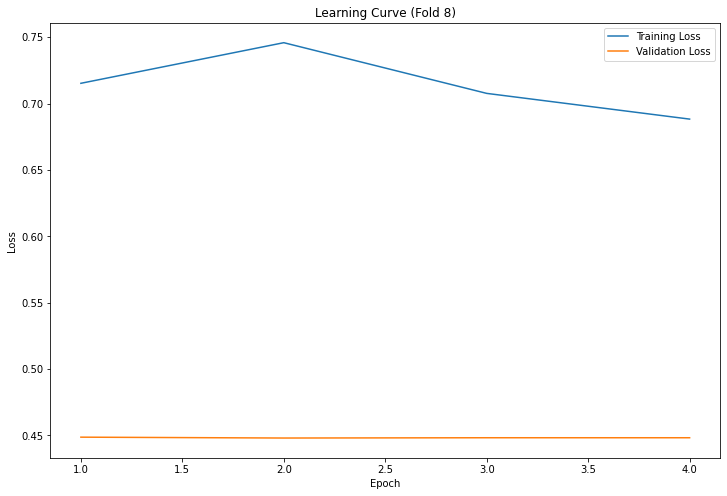

--------------DONE TRAINING MODEL FOR EarningsPerShareDiluted--------------




pytorch_model.bin:   0%|          | 0.00/439M [00:00<?, ?B/s]

In [16]:
# Define variables
batch_size = 32
epochs=40
initial_lr=2e-5
eps=1e-8
cv=10

for file in fb_files: 
    metric_name = file.split('.')[0].split('_')[0]

    print(f"--------------START TRAINING MODEL FOR {metric_name}--------------")

    # Read csv file
    df = pd.read_csv(fb_path + file)

    # Load model and tokenizer
    model, tokenizer = finbert_regressor()
    model.to(device)

    # Scale data
    scaler = StandardScaler()
    df['target'] = scaler.fit_transform(df['target'].values.reshape(-1, 1))

    # Prepare dataset
    dataset = prepare_labeled_datasets(tokenizer, model, 300, df['text'].values.tolist(), df['target'].values.tolist()) 

    # Train model
    best_model_overall, best_val_loss_overall, best_fold_overall, all_train_losses, all_val_losses, training_stats  = train_finbert_regressor(model, tokenizer, dataset, 
                                                                                            epochs=epochs, initial_lr=initial_lr, 
                                                                                            eps=eps, cv=cv)


    # Present results from the best model
    print("Results from the best model")
    print(f"Fold with best validation RSE: {best_fold_overall}")
    print("Best validation RSE: {0:.2f}".format(best_val_loss_overall)) 

    plot_learning_curve(training_stats,best_fold_overall)

    print(f"--------------DONE TRAINING MODEL FOR {metric_name}--------------")
    print("\n")

    # Save models
    # Check if model exists
    if best_model_overall is None:
        print("No model available")
    else:
        # Save models
        hub_path = 'lenguyen/' + 'finbert_' + metric_name  
        model.push_to_hub(hub_path)
        tokenizer.push_to_hub(hub_path)
        
        # Save scaler locally
        joblib.dump(scaler, f'../models/finbert_data/{metric_name}_scaler.pkl')


#### NetCashProvidedByUsedInInvestingActivities - FinBERT

--------------START TRAINING MODEL FOR NetCashProvidedByUsedInInvestingActivities--------------


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at yiyanghkust/finbert-pretrain and are newly initialized: ['transformer.layer.11.output_layer_norm.weight', 'transformer.layer.9.attention.k_lin.weight', 'transformer.layer.0.attention.v_lin.bias', 'transformer.layer.2.output_layer_norm.bias', 'transformer.layer.0.ffn.lin2.weight', 'transformer.layer.7.attention.q_lin.weight', 'classifier.bias', 'transformer.layer.4.ffn.lin1.weight', 'transformer.layer.4.attention.q_lin.weight', 'transformer.layer.0.sa_layer_norm.bias', 'transformer.layer.6.ffn.lin1.weight', 'transformer.layer.7.ffn.lin1.bias', 'transformer.layer.9.output_layer_norm.weight', 'transformer.layer.8.attention.out_lin.bias', 'transformer.layer.3.attention.out_lin.bias', 'transformer.layer.2.output_layer_norm.weight', 'transformer.layer.6.attention.out_lin.bias', 'transformer.layer.5.attention.k_lin.bias', 'transformer.layer.1.attention.out_lin.weight', 'transformer.layer.2.ff

Fold 1


 10%|█         | 4/40 [00:02<00:22,  1.59it/s]


Early stopping at epoch 5 in fold 1
Fold 1 - Best Validation Loss: 1.0225952863693237 at Epoch: 2
Fold 2


 22%|██▎       | 9/40 [00:04<00:17,  1.81it/s]


Early stopping at epoch 10 in fold 2
Fold 2 - Best Validation Loss: 0.9592956900596619 at Epoch: 7
Fold 3


  8%|▊         | 3/40 [00:01<00:24,  1.51it/s]


Early stopping at epoch 4 in fold 3
Fold 3 - Best Validation Loss: 0.9877448081970215 at Epoch: 1
Fold 4


  8%|▊         | 3/40 [00:01<00:24,  1.50it/s]


Early stopping at epoch 4 in fold 4
Fold 4 - Best Validation Loss: 1.0379140377044678 at Epoch: 1
Fold 5


 30%|███       | 12/40 [00:06<00:15,  1.86it/s]


Early stopping at epoch 13 in fold 5
Fold 5 - Best Validation Loss: 0.9619854688644409 at Epoch: 10
Fold 6


 25%|██▌       | 10/40 [00:05<00:16,  1.82it/s]


Early stopping at epoch 11 in fold 6
Fold 6 - Best Validation Loss: 0.9027571678161621 at Epoch: 8
Fold 7


 18%|█▊        | 7/40 [00:03<00:18,  1.77it/s]


Early stopping at epoch 8 in fold 7
Fold 7 - Best Validation Loss: 1.047881007194519 at Epoch: 5
Fold 8


100%|██████████| 40/40 [00:20<00:00,  2.00it/s]


Fold 8 - Best Validation Loss: 0.9544969797134399 at Epoch: 40
Fold 9


  8%|▊         | 3/40 [00:01<00:24,  1.51it/s]


Early stopping at epoch 4 in fold 9
Fold 9 - Best Validation Loss: 0.9050682783126831 at Epoch: 1
Fold 10


  8%|▊         | 3/40 [00:02<00:24,  1.50it/s]

Early stopping at epoch 4 in fold 10
Fold 10 - Best Validation Loss: 0.9716771841049194 at Epoch: 1
Results from the best model
Fold with best validation RSE: 6
Best validation RSE: 0.90


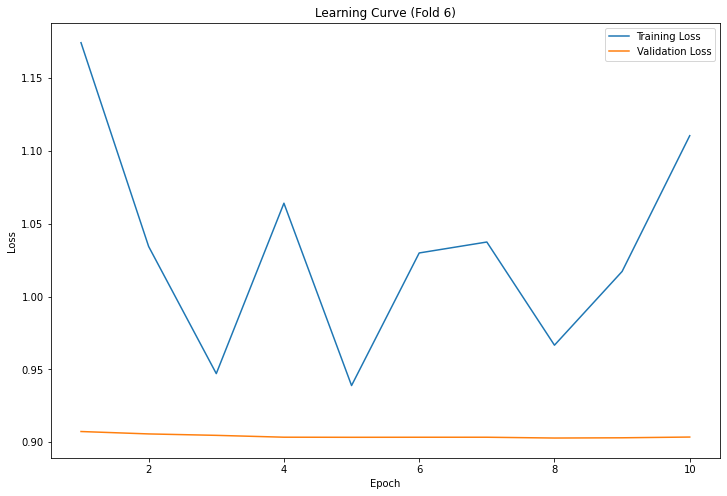

--------------DONE TRAINING MODEL FOR NetCashProvidedByUsedInInvestingActivities--------------




In [ ]:
# Define variables
batch_size = 16
epochs=40
initial_lr=2e-5
eps=1e-8
patience=3
cv=10
# Name metric
file = fb_files[0]
metric_name = file.split('.')[0].split('_')[0]

print(f"--------------START TRAINING MODEL FOR {metric_name}--------------")

# Read csv file
df = pd.read_csv(fb_path + file)

# Load model and tokenizer
model, tokenizer = finbert_regressor()
model.to(device)

# Scale data
scaler = StandardScaler()
df['target'] = scaler.fit_transform(df['target'].values.reshape(-1, 1))

# Prepare dataset
dataset = prepare_labeled_datasets(tokenizer, model, 300, df['text'].values.tolist(), df['target'].values.tolist()) 

# Train model
best_model_overall, best_val_loss_overall, best_fold_overall, all_train_losses, all_val_losses, training_stats  = train_finbert_regressor(model, tokenizer, dataset, 
                                                                                           epochs=epochs, initial_lr=initial_lr, 
                                                                                           eps=eps, cv=cv)


# Save models
# Check if model exists
if best_model_overall is None:
   print("No model available")
else:
   # Present results from the best model
   print("Results from the best model")
   print(f"Fold with best validation RSE: {best_fold_overall}")
   print("Best validation RSE: {0:.2f}".format(best_val_loss_overall)) 

   plot_learning_curve(training_stats,best_fold_overall)
   print(f"--------------DONE TRAINING MODEL FOR {metric_name}--------------")
   print("\n")
   # Save models
   hub_path = 'lenguyen/' + 'finbert_' + metric_name  
   model.push_to_hub(hub_path)
   tokenizer.push_to_hub(hub_path)
   
   # Save scaler locally
   joblib.dump(scaler, f'../models/finbert_data/{metric_name}_scaler.pkl')

--------------START TRAINING MODEL FOR NetCashProvidedByUsedInInvestingActivities--------------


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at yiyanghkust/finbert-pretrain and are newly initialized: ['transformer.layer.4.attention.q_lin.weight', 'transformer.layer.4.attention.k_lin.bias', 'transformer.layer.3.output_layer_norm.weight', 'transformer.layer.10.attention.v_lin.weight', 'transformer.layer.3.ffn.lin1.bias', 'transformer.layer.4.output_layer_norm.bias', 'transformer.layer.8.ffn.lin2.bias', 'transformer.layer.7.attention.v_lin.bias', 'transformer.layer.11.ffn.lin1.bias', 'transformer.layer.0.attention.v_lin.bias', 'transformer.layer.6.attention.out_lin.bias', 'transformer.layer.6.ffn.lin1.weight', 'transformer.layer.0.attention.out_lin.bias', 'transformer.layer.0.ffn.lin1.weight', 'transformer.layer.7.sa_layer_norm.bias', 'transformer.layer.2.attention.v_lin.bias', 'transformer.layer.2.attention.v_lin.weight', 'transformer.layer.3.ffn.lin2.weight', 'transformer.layer.0.output_layer_norm.bias', 'transformer.layer.6.ou

Fold 1


  8%|▊         | 3/40 [00:01<00:24,  1.52it/s]


Early stopping at epoch 4 in fold 1
Fold 1 - Best Validation Loss: 2.5383334159851074 at Epoch: 1
Fold 2


  8%|▊         | 3/40 [00:01<00:24,  1.54it/s]


Early stopping at epoch 4 in fold 2
Fold 2 - Best Validation Loss: 89.54370880126953 at Epoch: 1
Fold 3


  8%|▊         | 3/40 [00:01<00:24,  1.54it/s]


Early stopping at epoch 4 in fold 3
Fold 3 - Best Validation Loss: 3.676852226257324 at Epoch: 1
Fold 4


  8%|▊         | 3/40 [00:01<00:24,  1.54it/s]


Early stopping at epoch 4 in fold 4
Fold 4 - Best Validation Loss: 6.800379276275635 at Epoch: 1
Fold 5


  8%|▊         | 3/40 [00:01<00:24,  1.54it/s]


Early stopping at epoch 4 in fold 5
Fold 5 - Best Validation Loss: 2.6853158473968506 at Epoch: 1
Fold 6


  8%|▊         | 3/40 [00:01<00:24,  1.53it/s]


Early stopping at epoch 4 in fold 6
Fold 6 - Best Validation Loss: 10.018280029296875 at Epoch: 1
Fold 7


  8%|▊         | 3/40 [00:01<00:24,  1.54it/s]


Early stopping at epoch 4 in fold 7
Fold 7 - Best Validation Loss: 60.66123962402344 at Epoch: 1
Fold 8


  8%|▊         | 3/40 [00:01<00:24,  1.54it/s]


Early stopping at epoch 4 in fold 8
Fold 8 - Best Validation Loss: 5.713375568389893 at Epoch: 1
Fold 9


  8%|▊         | 3/40 [00:01<00:24,  1.54it/s]


Early stopping at epoch 4 in fold 9
Fold 9 - Best Validation Loss: 11.42203140258789 at Epoch: 1
Fold 10


  8%|▊         | 3/40 [00:01<00:24,  1.54it/s]

Early stopping at epoch 4 in fold 10
Fold 10 - Best Validation Loss: 2.144155740737915 at Epoch: 1


Results from the best model
Fold with best validation RSE: 10
Best validation RSE: 2.14


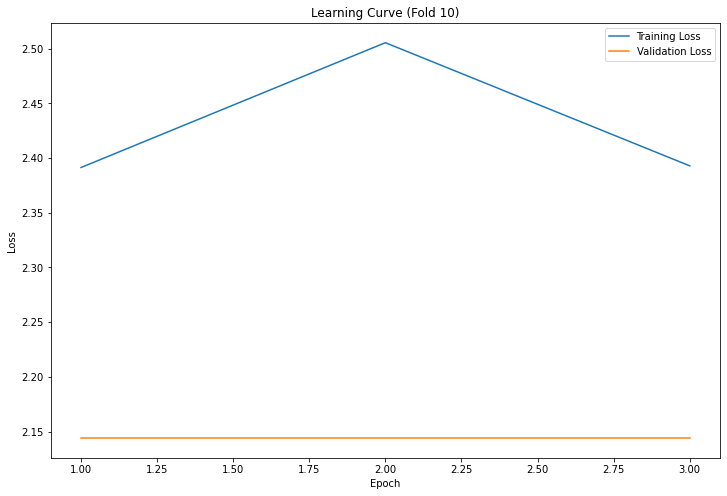

--------------DONE TRAINING MODEL FOR NetCashProvidedByUsedInInvestingActivities--------------




In [17]:
# Define variables
batch_size = 32
epochs=40
initial_lr=0.001
eps=1e-8
patience=5
cv=10


# Name metric
file = fb_files[0]
metric_name = file.split('.')[0].split('_')[0]

print(f"--------------START TRAINING MODEL FOR {metric_name}--------------")

# Read csv file
df = pd.read_csv(fb_path + file)

# Load model and tokenizer
model, tokenizer = finbert_regressor()
model.to(device)

# Prepare dataset
dataset = prepare_labeled_datasets(tokenizer, model, 300, df['text'].values.tolist(), df['target'].values.tolist()) 

# Train model
best_model_overall, best_val_loss_overall, best_fold_overall, all_train_losses, all_val_losses, training_stats  = train_finbert_regressor(model, tokenizer, dataset, 
                                                                                          epochs=epochs, initial_lr=initial_lr, 
                                                                                          eps=eps, cv=cv)  

# Save models
#If folder not available, create folder
if not os.path.exists('../models/finbert-regression/finbert_data/' + metric_name):
   os.makedirs('../models/finbert-regression/finbert_data/' + metric_name)
# Save model to folder
best_model_overall.save_pretrained('../models/finbert-regression/finbert_data/' + metric_name) 

# Present results from the best model
print("Results from the best model")
print(f"Fold with best validation RSE: {best_fold_overall}")
print("Best validation RSE: {0:.2f}".format(best_val_loss_overall)) 

plot_learning_curve(training_stats,best_fold_overall)
print(f"--------------DONE TRAINING MODEL FOR {metric_name}--------------")
print("\n")

#### EBIT - FinBERT

--------------START TRAINING MODEL FOR EBIT--------------


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at yiyanghkust/finbert-pretrain and are newly initialized: ['transformer.layer.11.output_layer_norm.weight', 'transformer.layer.9.attention.k_lin.weight', 'transformer.layer.0.attention.v_lin.bias', 'transformer.layer.2.output_layer_norm.bias', 'transformer.layer.0.ffn.lin2.weight', 'transformer.layer.7.attention.q_lin.weight', 'classifier.bias', 'transformer.layer.4.ffn.lin1.weight', 'transformer.layer.4.attention.q_lin.weight', 'transformer.layer.0.sa_layer_norm.bias', 'transformer.layer.6.ffn.lin1.weight', 'transformer.layer.7.ffn.lin1.bias', 'transformer.layer.9.output_layer_norm.weight', 'transformer.layer.8.attention.out_lin.bias', 'transformer.layer.3.attention.out_lin.bias', 'transformer.layer.2.output_layer_norm.weight', 'transformer.layer.6.attention.out_lin.bias', 'transformer.layer.5.attention.k_lin.bias', 'transformer.layer.1.attention.out_lin.weight', 'transformer.layer.2.ff

Fold 1


  8%|▊         | 3/40 [00:12<02:29,  4.04s/it]


Early stopping at epoch 4 in fold 1
Fold 1 - Best Validation Loss: 1.0695047974586487 at Epoch: 1
Fold 2


 10%|█         | 4/40 [00:15<02:15,  3.77s/it]


Early stopping at epoch 5 in fold 2
Fold 2 - Best Validation Loss: 1.0385994911193848 at Epoch: 2
Fold 3


  8%|▊         | 3/40 [00:12<02:29,  4.03s/it]


Early stopping at epoch 4 in fold 3
Fold 3 - Best Validation Loss: 1.1923319697380066 at Epoch: 1
Fold 4


 12%|█▎        | 5/40 [00:18<02:07,  3.63s/it]


Early stopping at epoch 6 in fold 4
Fold 4 - Best Validation Loss: 1.0193529725074768 at Epoch: 3
Fold 5


 18%|█▊        | 7/40 [00:24<01:54,  3.46s/it]


Early stopping at epoch 8 in fold 5
Fold 5 - Best Validation Loss: 1.1493030786514282 at Epoch: 5
Fold 6


 18%|█▊        | 7/40 [00:24<01:54,  3.46s/it]


Early stopping at epoch 8 in fold 6
Fold 6 - Best Validation Loss: 6.672525942325592 at Epoch: 5
Fold 7


  8%|▊         | 3/40 [00:12<02:29,  4.05s/it]


Early stopping at epoch 4 in fold 7
Fold 7 - Best Validation Loss: 8.37416598200798 at Epoch: 1
Fold 8


  8%|▊         | 3/40 [00:12<02:29,  4.04s/it]


Early stopping at epoch 4 in fold 8
Fold 8 - Best Validation Loss: 13.565409004688263 at Epoch: 1
Fold 9


  8%|▊         | 3/40 [00:12<02:30,  4.06s/it]


Early stopping at epoch 4 in fold 9
Fold 9 - Best Validation Loss: 1.8284651637077332 at Epoch: 1
Fold 10


 25%|██▌       | 10/40 [00:33<01:40,  3.34s/it]

Early stopping at epoch 11 in fold 10
Fold 10 - Best Validation Loss: 128.18037921190262 at Epoch: 8


Results from the best model
Fold with best validation RSE: 4
Best validation RSE: 1.02


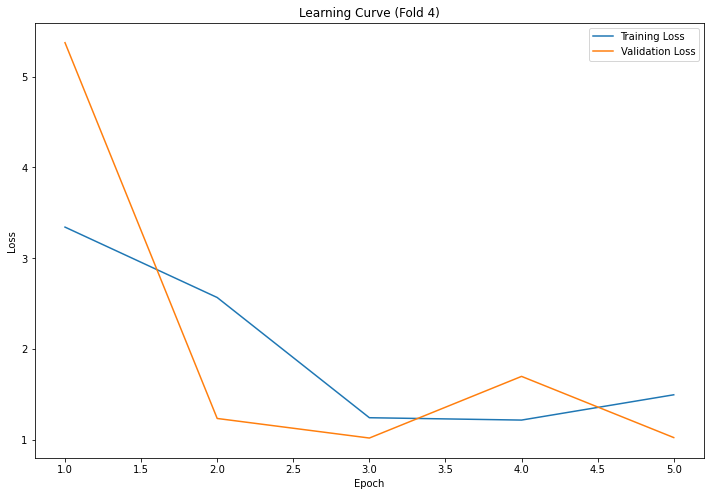

--------------DONE TRAINING MODEL FOR EBIT--------------




In [ ]:
# Define variables
batch_size = 16
epochs=40
initial_lr=2e-5
eps=1e-8
patience=5
cv=10
# Name metric
file = fb_files[1]
metric_name = file.split('.')[0].split('_')[0]

print(f"--------------START TRAINING MODEL FOR {metric_name}--------------")

# Read csv file
df = pd.read_csv(fb_path + file)

# Load model and tokenizer
model, tokenizer = finbert_regressor()
model.to(device)

# Scale data
scaler = StandardScaler()
df['target'] = scaler.fit_transform(df['target'].values.reshape(-1, 1))

# Prepare dataset
dataset = prepare_labeled_datasets(tokenizer, model, 300, df['text'].values.tolist(), df['target'].values.tolist()) 

# Train model
best_model_overall, best_val_loss_overall, best_fold_overall, all_train_losses, all_val_losses, training_stats  = train_finbert_regressor(model, tokenizer, dataset, 
                                                                                           epochs=epochs, initial_lr=initial_lr, 
                                                                                           eps=eps, cv=cv)


# Save models
# Check if model exists
if best_model_overall is None:
   print("No model available")
else:
   # Present results from the best model
   print("Results from the best model")
   print(f"Fold with best validation RSE: {best_fold_overall}")
   print("Best validation RSE: {0:.2f}".format(best_val_loss_overall)) 

   plot_learning_curve(training_stats,best_fold_overall)
   print(f"--------------DONE TRAINING MODEL FOR {metric_name}--------------")
   print("\n")
   # Save models
   hub_path = 'lenguyen/' + 'finbert_' + metric_name  
   model.push_to_hub(hub_path)
   tokenizer.push_to_hub(hub_path)
   
   # Save scaler locally
   joblib.dump(scaler, f'../models/finbert_data/{metric_name}_scaler.pkl')

--------------START TRAINING MODEL FOR EBIT--------------


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at yiyanghkust/finbert-pretrain and are newly initialized: ['transformer.layer.4.attention.q_lin.weight', 'transformer.layer.4.attention.k_lin.bias', 'transformer.layer.3.output_layer_norm.weight', 'transformer.layer.10.attention.v_lin.weight', 'transformer.layer.3.ffn.lin1.bias', 'transformer.layer.4.output_layer_norm.bias', 'transformer.layer.8.ffn.lin2.bias', 'transformer.layer.7.attention.v_lin.bias', 'transformer.layer.11.ffn.lin1.bias', 'transformer.layer.0.attention.v_lin.bias', 'transformer.layer.6.attention.out_lin.bias', 'transformer.layer.6.ffn.lin1.weight', 'transformer.layer.0.attention.out_lin.bias', 'transformer.layer.0.ffn.lin1.weight', 'transformer.layer.7.sa_layer_norm.bias', 'transformer.layer.2.attention.v_lin.bias', 'transformer.layer.2.attention.v_lin.weight', 'transformer.layer.3.ffn.lin2.weight', 'transformer.layer.0.output_layer_norm.bias', 'transformer.layer.6.ou

Fold 1


  8%|▊         | 3/40 [00:11<02:25,  3.95s/it]


Early stopping at epoch 4 in fold 1
Fold 1 - Best Validation Loss: 2.242705762386322 at Epoch: 1
Fold 2


  8%|▊         | 3/40 [00:11<02:26,  3.95s/it]


Early stopping at epoch 4 in fold 2
Fold 2 - Best Validation Loss: 2.855533003807068 at Epoch: 1
Fold 3


  8%|▊         | 3/40 [00:11<02:26,  3.96s/it]


Early stopping at epoch 4 in fold 3
Fold 3 - Best Validation Loss: 3.1527451276779175 at Epoch: 1
Fold 4


  8%|▊         | 3/40 [00:11<02:26,  3.95s/it]


Early stopping at epoch 4 in fold 4
Fold 4 - Best Validation Loss: 9.638983368873596 at Epoch: 1
Fold 5


  8%|▊         | 3/40 [00:11<02:26,  3.96s/it]


Early stopping at epoch 4 in fold 5
Fold 5 - Best Validation Loss: 2.9075546264648438 at Epoch: 1
Fold 6


  8%|▊         | 3/40 [00:11<02:26,  3.96s/it]


Early stopping at epoch 4 in fold 6
Fold 6 - Best Validation Loss: 18.868285357952118 at Epoch: 1
Fold 7


  8%|▊         | 3/40 [00:11<02:26,  3.96s/it]


Early stopping at epoch 4 in fold 7
Fold 7 - Best Validation Loss: 2.757692575454712 at Epoch: 1
Fold 8


  8%|▊         | 3/40 [00:11<02:27,  4.00s/it]


Early stopping at epoch 4 in fold 8
Fold 8 - Best Validation Loss: 3.2145403623580933 at Epoch: 1
Fold 9


  8%|▊         | 3/40 [00:12<02:28,  4.02s/it]


Early stopping at epoch 4 in fold 9
Fold 9 - Best Validation Loss: 15.863886296749115 at Epoch: 1
Fold 10


  8%|▊         | 3/40 [00:12<02:29,  4.05s/it]

Early stopping at epoch 4 in fold 10
Fold 10 - Best Validation Loss: 3.1162376403808594 at Epoch: 1


Results from the best model
Fold with best validation RSE: 1
Best validation RSE: 2.24


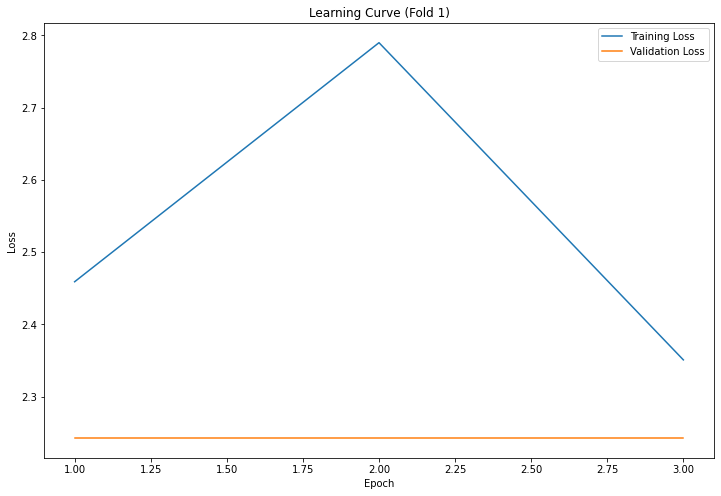

--------------DONE TRAINING MODEL FOR EBIT--------------




In [18]:
# Define variables
batch_size = 32
epochs=40
initial_lr=0.001
eps=1e-8
patience=5
cv=10


# Name metric
file = fb_files[1]
metric_name = file.split('.')[0].split('_')[0]

print(f"--------------START TRAINING MODEL FOR {metric_name}--------------")

# Read csv file
df = pd.read_csv(fb_path + file)

# Load model and tokenizer
model, tokenizer = finbert_regressor()
model.to(device)

# Prepare dataset
dataset = prepare_labeled_datasets(tokenizer, model, 300, df['text'].values.tolist(), df['target'].values.tolist()) 

# Train model
best_model_overall, best_val_loss_overall, best_fold_overall, all_train_losses, all_val_losses, training_stats  = train_finbert_regressor(model, tokenizer, dataset, 
                                                                                          epochs=epochs, initial_lr=initial_lr, 
                                                                                          eps=eps, cv=cv)  

# Save models
#If folder not available, create folder
if not os.path.exists('../models/finbert-regression/finbert_data/' + metric_name):
   os.makedirs('../models/finbert-regression/finbert_data/' + metric_name)
# Save model to folder
best_model_overall.save_pretrained('../models/finbert-regression/finbert_data/' + metric_name) 

# Present results from the best model
print("Results from the best model")
print(f"Fold with best validation RSE: {best_fold_overall}")
print("Best validation RSE: {0:.2f}".format(best_val_loss_overall)) 

plot_learning_curve(training_stats,best_fold_overall)
print(f"--------------DONE TRAINING MODEL FOR {metric_name}--------------")
print("\n")

#### NetCashProvidedByUsedInFinancingActivities - FinBERT

--------------START TRAINING MODEL FOR NetCashProvidedByUsedInFinancingActivities--------------


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at yiyanghkust/finbert-pretrain and are newly initialized: ['transformer.layer.1.ffn.lin1.bias', 'transformer.layer.10.attention.k_lin.bias', 'transformer.layer.5.attention.out_lin.weight', 'transformer.layer.0.ffn.lin1.weight', 'transformer.layer.1.sa_layer_norm.weight', 'transformer.layer.9.attention.v_lin.weight', 'transformer.layer.9.attention.out_lin.weight', 'transformer.layer.5.ffn.lin2.bias', 'transformer.layer.6.ffn.lin2.weight', 'transformer.layer.10.attention.out_lin.bias', 'embeddings.LayerNorm.bias', 'transformer.layer.0.ffn.lin1.bias', 'transformer.layer.11.ffn.lin1.weight', 'transformer.layer.3.sa_layer_norm.bias', 'transformer.layer.10.attention.k_lin.weight', 'transformer.layer.6.ffn.lin2.bias', 'transformer.layer.0.sa_layer_norm.bias', 'transformer.layer.4.attention.k_lin.bias', 'transformer.layer.1.attention.k_lin.weight', 'transformer.layer.5.attention.v_lin.weight', '

Fold 1


 18%|█▊        | 7/40 [00:02<00:09,  3.35it/s]


Early stopping at epoch 8 in fold 1
Fold 1 - Best Validation Loss: 1.0017738342285156 at Epoch: 5
Fold 2


  8%|▊         | 3/40 [00:01<00:12,  2.88it/s]


Early stopping at epoch 4 in fold 2
Fold 2 - Best Validation Loss: 17.08699607849121 at Epoch: 1
Fold 3


 22%|██▎       | 9/40 [00:02<00:08,  3.46it/s]


Early stopping at epoch 10 in fold 3
Fold 3 - Best Validation Loss: 1.6033122539520264 at Epoch: 7
Fold 4


 15%|█▌        | 6/40 [00:01<00:10,  3.28it/s]


Early stopping at epoch 7 in fold 4
Fold 4 - Best Validation Loss: 1.00142240524292 at Epoch: 4
Fold 5


  8%|▊         | 3/40 [00:01<00:12,  2.88it/s]


Early stopping at epoch 4 in fold 5
Fold 5 - Best Validation Loss: 1.942538857460022 at Epoch: 1
Fold 6


 15%|█▌        | 6/40 [00:01<00:10,  3.30it/s]


Early stopping at epoch 7 in fold 6
Fold 6 - Best Validation Loss: 13.454730987548828 at Epoch: 4
Fold 7


  5%|▌         | 2/40 [00:00<00:15,  2.46it/s]


Early stopping at epoch 3 in fold 7
Fold 7 - Best Validation Loss: inf at Epoch: 0
Fold 8


  5%|▌         | 2/40 [00:00<00:15,  2.46it/s]


Early stopping at epoch 3 in fold 8
Fold 8 - Best Validation Loss: inf at Epoch: 0
Fold 9


  5%|▌         | 2/40 [00:00<00:15,  2.47it/s]


Early stopping at epoch 3 in fold 9
Fold 9 - Best Validation Loss: inf at Epoch: 0
Fold 10


  5%|▌         | 2/40 [00:00<00:15,  2.46it/s]

Early stopping at epoch 3 in fold 10
Fold 10 - Best Validation Loss: inf at Epoch: 0
Results from the best model
Fold with best validation RSE: 4
Best validation RSE: 1.00


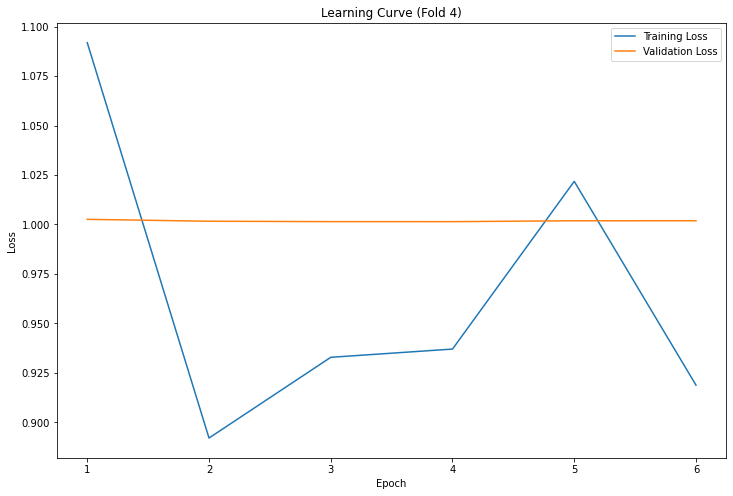

--------------DONE TRAINING MODEL FOR NetCashProvidedByUsedInFinancingActivities--------------




In [ ]:
# Define variables
batch_size = 16
epochs=40
initial_lr=2e-5
eps=1e-8
patience=3
cv=10
# Name metric
file = fb_files[2]
metric_name = file.split('.')[0].split('_')[0]

print(f"--------------START TRAINING MODEL FOR {metric_name}--------------")

# Read csv file
df = pd.read_csv(fb_path + file)

# Load model and tokenizer
model, tokenizer = finbert_regressor()
model.to(device)

# Scale data
scaler = StandardScaler()
df['target'] = scaler.fit_transform(df['target'].values.reshape(-1, 1))

# Prepare dataset
dataset = prepare_labeled_datasets(tokenizer, model, 300, df['text'].values.tolist(), df['target'].values.tolist()) 

# Train model
best_model_overall, best_val_loss_overall, best_fold_overall, all_train_losses, all_val_losses, training_stats  = train_finbert_regressor(model, tokenizer, dataset, 
                                                                                           epochs=epochs, initial_lr=initial_lr, 
                                                                                           eps=eps, cv=cv)


# Save models
# Check if model exists
if best_model_overall is None:
   print("No model available")
else:
   # Present results from the best model
   print("Results from the best model")
   print(f"Fold with best validation RSE: {best_fold_overall}")
   print("Best validation RSE: {0:.2f}".format(best_val_loss_overall)) 

   plot_learning_curve(training_stats,best_fold_overall)
   print(f"--------------DONE TRAINING MODEL FOR {metric_name}--------------")
   print("\n")
   # Save models
   hub_path = 'lenguyen/' + 'finbert_' + metric_name  
   model.push_to_hub(hub_path)
   tokenizer.push_to_hub(hub_path)
   
   # Save scaler locally
   joblib.dump(scaler, f'../models/finbert_data/{metric_name}_scaler.pkl')

--------------START TRAINING MODEL FOR NetCashProvidedByUsedInFinancingActivities--------------


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at yiyanghkust/finbert-pretrain and are newly initialized: ['transformer.layer.4.attention.q_lin.weight', 'transformer.layer.4.attention.k_lin.bias', 'transformer.layer.3.output_layer_norm.weight', 'transformer.layer.10.attention.v_lin.weight', 'transformer.layer.3.ffn.lin1.bias', 'transformer.layer.4.output_layer_norm.bias', 'transformer.layer.8.ffn.lin2.bias', 'transformer.layer.7.attention.v_lin.bias', 'transformer.layer.11.ffn.lin1.bias', 'transformer.layer.0.attention.v_lin.bias', 'transformer.layer.6.attention.out_lin.bias', 'transformer.layer.6.ffn.lin1.weight', 'transformer.layer.0.attention.out_lin.bias', 'transformer.layer.0.ffn.lin1.weight', 'transformer.layer.7.sa_layer_norm.bias', 'transformer.layer.2.attention.v_lin.bias', 'transformer.layer.2.attention.v_lin.weight', 'transformer.layer.3.ffn.lin2.weight', 'transformer.layer.0.output_layer_norm.bias', 'transformer.layer.6.ou

Fold 1


  8%|▊         | 3/40 [00:01<00:13,  2.74it/s]


Early stopping at epoch 4 in fold 1
Fold 1 - Best Validation Loss: 1.368654727935791 at Epoch: 1
Fold 2


  8%|▊         | 3/40 [00:01<00:13,  2.71it/s]


Early stopping at epoch 4 in fold 2
Fold 2 - Best Validation Loss: 1.0090216398239136 at Epoch: 1
Fold 3


  8%|▊         | 3/40 [00:01<00:13,  2.82it/s]


Early stopping at epoch 4 in fold 3
Fold 3 - Best Validation Loss: 2.6338000297546387 at Epoch: 1
Fold 4


  5%|▌         | 2/40 [00:00<00:15,  2.39it/s]


Early stopping at epoch 3 in fold 4
Fold 4 - Best Validation Loss: inf at Epoch: 0
Fold 5


  8%|▊         | 3/40 [00:01<00:13,  2.67it/s]


Early stopping at epoch 4 in fold 5
Fold 5 - Best Validation Loss: 12.812119483947754 at Epoch: 1
Fold 6


  8%|▊         | 3/40 [00:01<00:13,  2.73it/s]


Early stopping at epoch 4 in fold 6
Fold 6 - Best Validation Loss: 30.117061614990234 at Epoch: 1
Fold 7


  5%|▌         | 2/40 [00:00<00:16,  2.33it/s]


Early stopping at epoch 3 in fold 7
Fold 7 - Best Validation Loss: inf at Epoch: 0
Fold 8


  5%|▌         | 2/40 [00:00<00:16,  2.34it/s]


Early stopping at epoch 3 in fold 8
Fold 8 - Best Validation Loss: inf at Epoch: 0
Fold 9


  5%|▌         | 2/40 [00:00<00:16,  2.30it/s]


Early stopping at epoch 3 in fold 9
Fold 9 - Best Validation Loss: inf at Epoch: 0
Fold 10


  5%|▌         | 2/40 [00:00<00:16,  2.33it/s]

Early stopping at epoch 3 in fold 10
Fold 10 - Best Validation Loss: inf at Epoch: 0


Results from the best model
Fold with best validation RSE: 2
Best validation RSE: 1.01


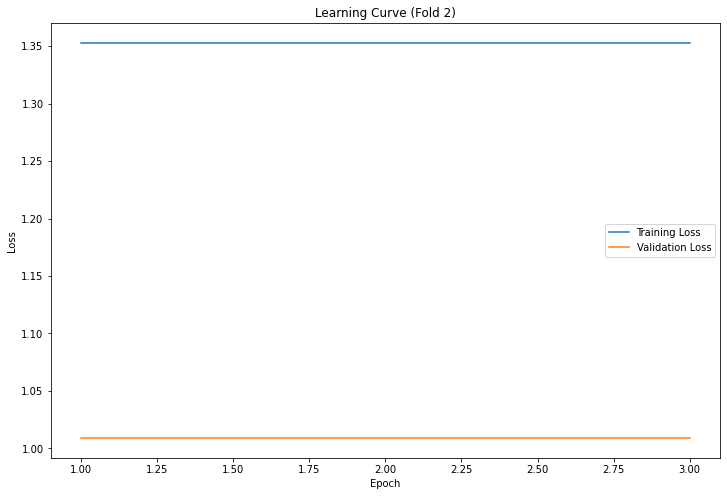

--------------DONE TRAINING MODEL FOR NetCashProvidedByUsedInFinancingActivities--------------




In [19]:
# Define variables
batch_size = 16
epochs=40
initial_lr=0.0001
eps=1e-8
patience=3
cv=10


# Name metric
file = fb_files[2]
metric_name = file.split('.')[0].split('_')[0]

print(f"--------------START TRAINING MODEL FOR {metric_name}--------------")

# Read csv file
df = pd.read_csv(fb_path + file)

# Load model and tokenizer
model, tokenizer = finbert_regressor()
model.to(device)

# Prepare dataset
dataset = prepare_labeled_datasets(tokenizer, model, 300, df['text'].values.tolist(), df['target'].values.tolist()) 

# Train model
best_model_overall, best_val_loss_overall, best_fold_overall, all_train_losses, all_val_losses, training_stats  = train_finbert_regressor(model, tokenizer, dataset, 
                                                                                          epochs=epochs, initial_lr=initial_lr, 
                                                                                          eps=eps, cv=cv)  

# Save models
#If folder not available, create folder
if not os.path.exists('../models/finbert-regression/finbert_data/' + metric_name):
   os.makedirs('../models/finbert-regression/finbert_data/' + metric_name)
# Save model to folder
best_model_overall.save_pretrained('../models/finbert-regression/finbert_data/' + metric_name) 

# Present results from the best model
print("Results from the best model")
print(f"Fold with best validation RSE: {best_fold_overall}")
print("Best validation RSE: {0:.2f}".format(best_val_loss_overall)) 

plot_learning_curve(training_stats,best_fold_overall)
print(f"--------------DONE TRAINING MODEL FOR {metric_name}--------------")
print("\n")

#### Revenue - FinBERT

--------------START TRAINING MODEL FOR RevenueFromContractWithCustomerExcludingAssessedTax--------------


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at yiyanghkust/finbert-pretrain and are newly initialized: ['transformer.layer.1.ffn.lin1.bias', 'transformer.layer.10.attention.k_lin.bias', 'transformer.layer.5.attention.out_lin.weight', 'transformer.layer.0.ffn.lin1.weight', 'transformer.layer.1.sa_layer_norm.weight', 'transformer.layer.9.attention.v_lin.weight', 'transformer.layer.9.attention.out_lin.weight', 'transformer.layer.5.ffn.lin2.bias', 'transformer.layer.6.ffn.lin2.weight', 'transformer.layer.10.attention.out_lin.bias', 'embeddings.LayerNorm.bias', 'transformer.layer.0.ffn.lin1.bias', 'transformer.layer.11.ffn.lin1.weight', 'transformer.layer.3.sa_layer_norm.bias', 'transformer.layer.10.attention.k_lin.weight', 'transformer.layer.6.ffn.lin2.bias', 'transformer.layer.0.sa_layer_norm.bias', 'transformer.layer.4.attention.k_lin.bias', 'transformer.layer.1.attention.k_lin.weight', 'transformer.layer.5.attention.v_lin.weight', '

Fold 1


 22%|██▎       | 9/40 [16:27<56:41, 109.74s/it] 


Early stopping at epoch 10 in fold 1
Fold 1 - Best Validation Loss: 1.6154268711805344 at Epoch: 7
Fold 2


 20%|██        | 8/40 [14:51<59:24, 111.40s/it] 


Early stopping at epoch 9 in fold 2
Fold 2 - Best Validation Loss: 0.7619193311780691 at Epoch: 6
Fold 3


  8%|▊         | 3/40 [06:34<1:21:10, 131.64s/it]


Early stopping at epoch 4 in fold 3
Fold 3 - Best Validation Loss: 0.576500803232193 at Epoch: 1
Fold 4


 10%|█         | 4/40 [08:12<1:13:55, 123.20s/it]


Early stopping at epoch 5 in fold 4
Fold 4 - Best Validation Loss: 1.0260851673781872 at Epoch: 2
Fold 5


 20%|██        | 8/40 [14:46<59:07, 110.85s/it] 


Early stopping at epoch 9 in fold 5
Fold 5 - Best Validation Loss: 0.45908628962934017 at Epoch: 6
Fold 6


  5%|▌         | 2/40 [04:55<1:33:27, 147.56s/it]


Early stopping at epoch 3 in fold 6
Fold 6 - Best Validation Loss: inf at Epoch: 0
Fold 7


  5%|▌         | 2/40 [04:55<1:33:27, 147.58s/it]


Early stopping at epoch 3 in fold 7
Fold 7 - Best Validation Loss: inf at Epoch: 0
Fold 8


  5%|▌         | 2/40 [04:55<1:33:25, 147.52s/it]


Early stopping at epoch 3 in fold 8
Fold 8 - Best Validation Loss: inf at Epoch: 0
Fold 9


  5%|▌         | 2/40 [04:55<1:33:28, 147.59s/it]


Early stopping at epoch 3 in fold 9
Fold 9 - Best Validation Loss: inf at Epoch: 0
Fold 10


  5%|▌         | 2/40 [04:55<1:33:33, 147.73s/it]

Early stopping at epoch 3 in fold 10
Fold 10 - Best Validation Loss: inf at Epoch: 0
Results from the best model
Fold with best validation RSE: 5
Best validation RSE: 0.46


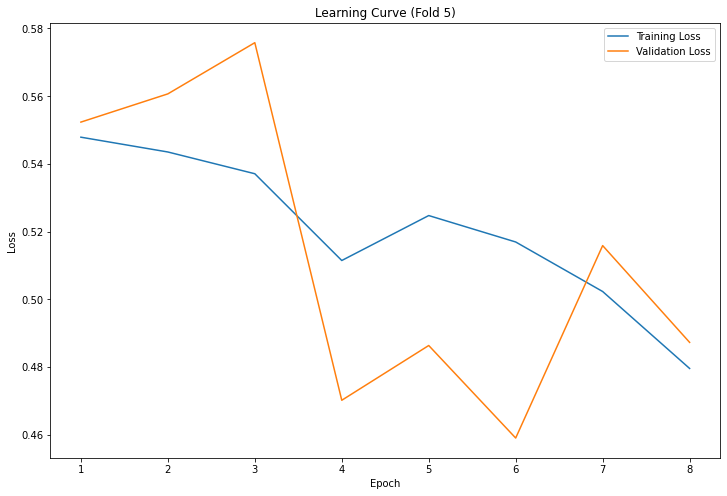

--------------DONE TRAINING MODEL FOR RevenueFromContractWithCustomerExcludingAssessedTax--------------




In [ ]:
# Define variables
batch_size = 32
epochs=40
initial_lr=2e-5
eps=1e-8
patience=5
cv=10
# Name metric
file = fb_files[3]
metric_name = file.split('.')[0].split('_')[0]

print(f"--------------START TRAINING MODEL FOR {metric_name}--------------")

# Read csv file
df = pd.read_csv(fb_path + file)

# Load model and tokenizer
model, tokenizer = finbert_regressor()
model.to(device)

# Scale data
scaler = StandardScaler()
df['target'] = scaler.fit_transform(df['target'].values.reshape(-1, 1))

# Prepare dataset
dataset = prepare_labeled_datasets(tokenizer, model, 300, df['text'].values.tolist(), df['target'].values.tolist()) 

# Train model
best_model_overall, best_val_loss_overall, best_fold_overall, all_train_losses, all_val_losses, training_stats  = train_finbert_regressor(model, tokenizer, dataset, 
                                                                                           epochs=epochs, initial_lr=initial_lr, 
                                                                                           eps=eps, cv=cv)



# Save models
# Check if model exists
if best_model_overall is None:
   print("No model available")
else:
   # Present results from the best model
   print("Results from the best model")
   print(f"Fold with best validation RSE: {best_fold_overall}")
   print("Best validation RSE: {0:.2f}".format(best_val_loss_overall)) 

   plot_learning_curve(training_stats,best_fold_overall)
   print(f"--------------DONE TRAINING MODEL FOR {metric_name}--------------")
   print("\n")
   # Save models
   hub_path = 'lenguyen/' + 'finbert_' + metric_name  
   model.push_to_hub(hub_path)
   tokenizer.push_to_hub(hub_path)
   
   # Save scaler locally
   joblib.dump(scaler, f'../models/finbert_data/{metric_name}_scaler.pkl')

--------------START TRAINING MODEL FOR RevenueFromContractWithCustomerExcludingAssessedTax--------------


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at yiyanghkust/finbert-pretrain and are newly initialized: ['transformer.layer.4.attention.q_lin.weight', 'transformer.layer.4.attention.k_lin.bias', 'transformer.layer.3.output_layer_norm.weight', 'transformer.layer.10.attention.v_lin.weight', 'transformer.layer.3.ffn.lin1.bias', 'transformer.layer.4.output_layer_norm.bias', 'transformer.layer.8.ffn.lin2.bias', 'transformer.layer.7.attention.v_lin.bias', 'transformer.layer.11.ffn.lin1.bias', 'transformer.layer.0.attention.v_lin.bias', 'transformer.layer.6.attention.out_lin.bias', 'transformer.layer.6.ffn.lin1.weight', 'transformer.layer.0.attention.out_lin.bias', 'transformer.layer.0.ffn.lin1.weight', 'transformer.layer.7.sa_layer_norm.bias', 'transformer.layer.2.attention.v_lin.bias', 'transformer.layer.2.attention.v_lin.weight', 'transformer.layer.3.ffn.lin2.weight', 'transformer.layer.0.output_layer_norm.bias', 'transformer.layer.6.ou

Fold 1


  8%|▊         | 3/40 [06:44<1:23:06, 134.77s/it]


Early stopping at epoch 4 in fold 1
Fold 1 - Best Validation Loss: 2.6829051673412323 at Epoch: 1
Fold 2


  8%|▊         | 3/40 [06:44<1:23:09, 134.86s/it]


Early stopping at epoch 4 in fold 2
Fold 2 - Best Validation Loss: 2.5887555211782454 at Epoch: 1
Fold 3


  8%|▊         | 3/40 [06:44<1:23:05, 134.74s/it]


Early stopping at epoch 4 in fold 3
Fold 3 - Best Validation Loss: 2.3099751621484756 at Epoch: 1
Fold 4


  8%|▊         | 3/40 [06:44<1:23:12, 134.94s/it]


Early stopping at epoch 4 in fold 4
Fold 4 - Best Validation Loss: 2.4501290023326874 at Epoch: 1
Fold 5


  8%|▊         | 3/40 [06:44<1:23:06, 134.78s/it]


Early stopping at epoch 4 in fold 5
Fold 5 - Best Validation Loss: 2.325967568159103 at Epoch: 1
Fold 6


  5%|▌         | 2/40 [05:03<1:36:02, 151.65s/it]


Early stopping at epoch 3 in fold 6
Fold 6 - Best Validation Loss: inf at Epoch: 0
Fold 7


  5%|▌         | 2/40 [05:03<1:35:58, 151.54s/it]


Early stopping at epoch 3 in fold 7
Fold 7 - Best Validation Loss: inf at Epoch: 0
Fold 8


  5%|▌         | 2/40 [05:03<1:36:01, 151.61s/it]


Early stopping at epoch 3 in fold 8
Fold 8 - Best Validation Loss: inf at Epoch: 0
Fold 9


  5%|▌         | 2/40 [05:03<1:35:58, 151.53s/it]


Early stopping at epoch 3 in fold 9
Fold 9 - Best Validation Loss: inf at Epoch: 0
Fold 10


  5%|▌         | 2/40 [05:03<1:36:04, 151.71s/it]

Early stopping at epoch 3 in fold 10
Fold 10 - Best Validation Loss: inf at Epoch: 0


Results from the best model
Fold with best validation RSE: 3
Best validation RSE: 2.31


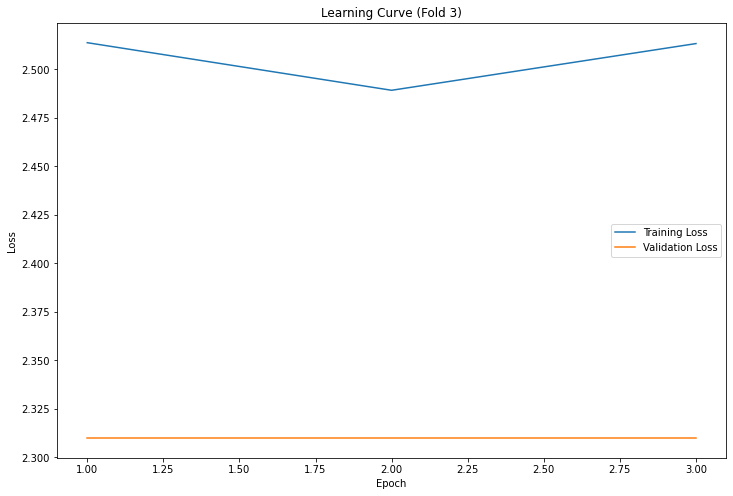

--------------DONE TRAINING MODEL FOR RevenueFromContractWithCustomerExcludingAssessedTax--------------




In [20]:
# Define variables
batch_size = 32
epochs=40
initial_lr=0.0001 # change to 0.0001 would be better because it will be more stable, 0.001 is too large
eps=1e-8
patience=5
cv=10


# Name metric
file = fb_files[3]
metric_name = file.split('.')[0].split('_')[0]

print(f"--------------START TRAINING MODEL FOR {metric_name}--------------")

# Read csv file
df = pd.read_csv(fb_path + file)

# Load model and tokenizer
model, tokenizer = finbert_regressor()
model.to(device)

# Prepare dataset
dataset = prepare_labeled_datasets(tokenizer, model, 300, df['text'].values.tolist(), df['target'].values.tolist()) 

# Train model
best_model_overall, best_val_loss_overall, best_fold_overall, all_train_losses, all_val_losses, training_stats  = train_finbert_regressor(model, tokenizer, dataset, 
                                                                                          epochs=epochs, initial_lr=initial_lr, 
                                                                                          eps=eps, cv=cv)  

# Save models
#If folder not available, create folder
if not os.path.exists('../models/finbert-regression/finbert_data/' + metric_name):
   os.makedirs('../models/finbert-regression/finbert_data/' + metric_name)
# Save model to folder
best_model_overall.save_pretrained('../models/finbert-regression/finbert_data/' + metric_name) 

# Present results from the best model
print("Results from the best model")
print(f"Fold with best validation RSE: {best_fold_overall}")
print("Best validation RSE: {0:.2f}".format(best_val_loss_overall)) 

plot_learning_curve(training_stats,best_fold_overall)
print(f"--------------DONE TRAINING MODEL FOR {metric_name}--------------")
print("\n")

#### NetIncomeLoss - FinBERT

--------------START TRAINING MODEL FOR NetIncomeLoss--------------


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at yiyanghkust/finbert-pretrain and are newly initialized: ['transformer.layer.1.ffn.lin1.bias', 'transformer.layer.10.attention.k_lin.bias', 'transformer.layer.5.attention.out_lin.weight', 'transformer.layer.0.ffn.lin1.weight', 'transformer.layer.1.sa_layer_norm.weight', 'transformer.layer.9.attention.v_lin.weight', 'transformer.layer.9.attention.out_lin.weight', 'transformer.layer.5.ffn.lin2.bias', 'transformer.layer.6.ffn.lin2.weight', 'transformer.layer.10.attention.out_lin.bias', 'embeddings.LayerNorm.bias', 'transformer.layer.0.ffn.lin1.bias', 'transformer.layer.11.ffn.lin1.weight', 'transformer.layer.3.sa_layer_norm.bias', 'transformer.layer.10.attention.k_lin.weight', 'transformer.layer.6.ffn.lin2.bias', 'transformer.layer.0.sa_layer_norm.bias', 'transformer.layer.4.attention.k_lin.bias', 'transformer.layer.1.attention.k_lin.weight', 'transformer.layer.5.attention.v_lin.weight', '

Fold 1


 30%|███       | 12/40 [31:05<1:12:32, 155.45s/it]


Early stopping at epoch 13 in fold 1
Fold 1 - Best Validation Loss: 0.9081764668226242 at Epoch: 10
Fold 2


  8%|▊         | 3/40 [09:33<1:57:51, 191.12s/it]


Early stopping at epoch 4 in fold 2
Fold 2 - Best Validation Loss: 0.5337578573360525 at Epoch: 1
Fold 3


  8%|▊         | 3/40 [09:34<1:58:03, 191.45s/it]


Early stopping at epoch 4 in fold 3
Fold 3 - Best Validation Loss: 0.467736899981211 at Epoch: 1
Fold 4


 10%|█         | 4/40 [11:56<1:47:30, 179.18s/it]


Early stopping at epoch 5 in fold 4
Fold 4 - Best Validation Loss: 0.3829459387423663 at Epoch: 2
Fold 5


  8%|▊         | 3/40 [09:33<1:57:50, 191.08s/it]


Early stopping at epoch 4 in fold 5
Fold 5 - Best Validation Loss: 0.516129537774571 at Epoch: 1
Fold 6


  8%|▊         | 3/40 [09:33<1:57:54, 191.19s/it]


Early stopping at epoch 4 in fold 6
Fold 6 - Best Validation Loss: 6.15862185944771 at Epoch: 1
Fold 7


 10%|█         | 4/40 [11:58<1:47:43, 179.54s/it]


Early stopping at epoch 5 in fold 7
Fold 7 - Best Validation Loss: 0.471484600983817 at Epoch: 2
Fold 8


  5%|▌         | 2/40 [07:10<2:16:19, 215.25s/it]


Early stopping at epoch 3 in fold 8
Fold 8 - Best Validation Loss: inf at Epoch: 0
Fold 9


  5%|▌         | 2/40 [07:11<2:16:34, 215.65s/it]


Early stopping at epoch 3 in fold 9
Fold 9 - Best Validation Loss: inf at Epoch: 0
Fold 10


  5%|▌         | 2/40 [07:10<2:16:22, 215.34s/it]

Early stopping at epoch 3 in fold 10
Fold 10 - Best Validation Loss: inf at Epoch: 0
Results from the best model
Fold with best validation RSE: 4
Best validation RSE: 0.38


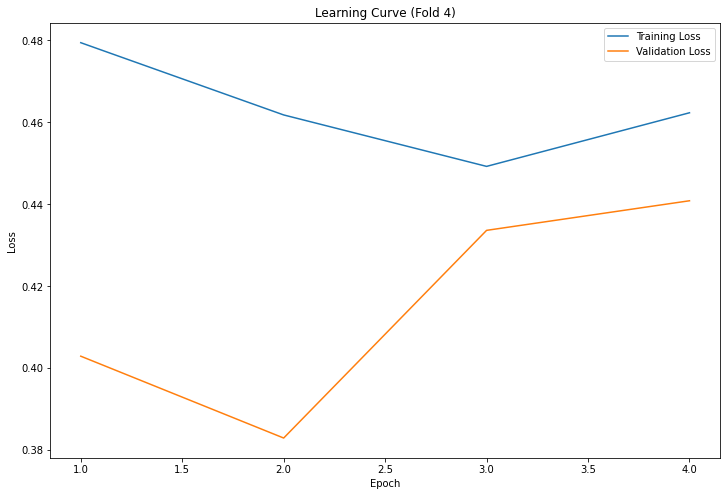

--------------DONE TRAINING MODEL FOR NetIncomeLoss--------------




In [ ]:
# Define variables
batch_size = 32
epochs=40
initial_lr=2e-5
eps=1e-8
patience=5
cv=10
# Name metric
file = fb_files[4]
metric_name = file.split('.')[0].split('_')[0]

print(f"--------------START TRAINING MODEL FOR {metric_name}--------------")

# Read csv file
df = pd.read_csv(fb_path + file)

# Load model and tokenizer
model, tokenizer = finbert_regressor()
model.to(device)

# Scale data
scaler = StandardScaler()
df['target'] = scaler.fit_transform(df['target'].values.reshape(-1, 1))

# Prepare dataset
dataset = prepare_labeled_datasets(tokenizer, model, 300, df['text'].values.tolist(), df['target'].values.tolist()) 

# Train model
best_model_overall, best_val_loss_overall, best_fold_overall, all_train_losses, all_val_losses, training_stats  = train_finbert_regressor(model, tokenizer, dataset, 
                                                                                           epochs=epochs, initial_lr=initial_lr, 
                                                                                           eps=eps, cv=cv)



# Save models
# Check if model exists
if best_model_overall is None:
   print("No model available")
else:
   # Present results from the best model
   print("Results from the best model")
   print(f"Fold with best validation RSE: {best_fold_overall}")
   print("Best validation RSE: {0:.2f}".format(best_val_loss_overall)) 

   plot_learning_curve(training_stats,best_fold_overall)
   print(f"--------------DONE TRAINING MODEL FOR {metric_name}--------------")
   print("\n")
   # Save models
   hub_path = 'lenguyen/' + 'finbert_' + metric_name  
   model.push_to_hub(hub_path)
   tokenizer.push_to_hub(hub_path)
   
   # Save scaler locally
   joblib.dump(scaler, f'../models/finbert_data/{metric_name}_scaler.pkl')

--------------START TRAINING MODEL FOR NetIncomeLoss--------------


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at yiyanghkust/finbert-pretrain and are newly initialized: ['transformer.layer.11.output_layer_norm.weight', 'transformer.layer.9.attention.k_lin.weight', 'transformer.layer.0.attention.v_lin.bias', 'transformer.layer.2.output_layer_norm.bias', 'transformer.layer.0.ffn.lin2.weight', 'transformer.layer.7.attention.q_lin.weight', 'classifier.bias', 'transformer.layer.4.ffn.lin1.weight', 'transformer.layer.4.attention.q_lin.weight', 'transformer.layer.0.sa_layer_norm.bias', 'transformer.layer.6.ffn.lin1.weight', 'transformer.layer.7.ffn.lin1.bias', 'transformer.layer.9.output_layer_norm.weight', 'transformer.layer.8.attention.out_lin.bias', 'transformer.layer.3.attention.out_lin.bias', 'transformer.layer.2.output_layer_norm.weight', 'transformer.layer.6.attention.out_lin.bias', 'transformer.layer.5.attention.k_lin.bias', 'transformer.layer.1.attention.out_lin.weight', 'transformer.layer.2.ff

Fold 1


  8%|▊         | 3/40 [09:39<1:59:07, 193.18s/it]


Early stopping at epoch 4 in fold 1
Fold 1 - Best Validation Loss: 2.2095000024499565 at Epoch: 1
Fold 2


  8%|▊         | 3/40 [09:37<1:58:36, 192.34s/it]


Early stopping at epoch 4 in fold 2
Fold 2 - Best Validation Loss: 21.98013110818534 at Epoch: 1
Fold 3


  8%|▊         | 3/40 [09:37<1:58:37, 192.38s/it]


Early stopping at epoch 4 in fold 3
Fold 3 - Best Validation Loss: 2.030342893353824 at Epoch: 1
Fold 4


  8%|▊         | 3/40 [09:37<1:58:36, 192.34s/it]


Early stopping at epoch 4 in fold 4
Fold 4 - Best Validation Loss: 2.1506046159514067 at Epoch: 1
Fold 5


  8%|▊         | 3/40 [09:38<1:58:59, 192.96s/it]


Early stopping at epoch 4 in fold 5
Fold 5 - Best Validation Loss: 2.0388384810809432 at Epoch: 1
Fold 6


  8%|▊         | 3/40 [09:37<1:58:36, 192.35s/it]


Early stopping at epoch 4 in fold 6
Fold 6 - Best Validation Loss: 2.1850681428251595 at Epoch: 1
Fold 7


  8%|▊         | 3/40 [09:37<1:58:39, 192.41s/it]


Early stopping at epoch 4 in fold 7
Fold 7 - Best Validation Loss: 2.2645771503448486 at Epoch: 1
Fold 8


  5%|▌         | 2/40 [07:12<2:16:50, 216.07s/it]


Early stopping at epoch 3 in fold 8
Fold 8 - Best Validation Loss: inf at Epoch: 0
Fold 9


  5%|▌         | 2/40 [07:12<2:16:52, 216.12s/it]


Early stopping at epoch 3 in fold 9
Fold 9 - Best Validation Loss: inf at Epoch: 0
Fold 10


  5%|▌         | 2/40 [07:12<2:17:00, 216.32s/it]

Early stopping at epoch 3 in fold 10
Fold 10 - Best Validation Loss: inf at Epoch: 0
Results from the best model
Fold with best validation RSE: 3
Best validation RSE: 2.03


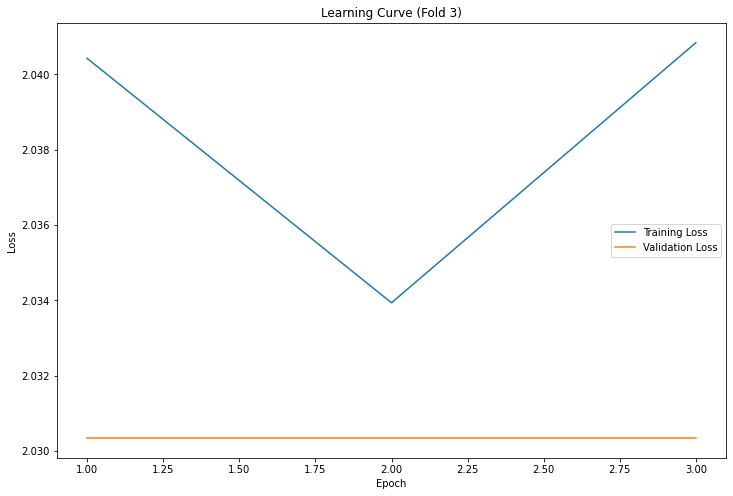

--------------DONE TRAINING MODEL FOR NetIncomeLoss--------------




In [32]:
# Define variables
batch_size = 32
epochs=40
initial_lr=2e-5
eps=1e-8
patience=5
cv=10


# Name metric
file = fb_files[4]
metric_name = file.split('.')[0].split('_')[0]

print(f"--------------START TRAINING MODEL FOR {metric_name}--------------")

# Read csv file
df = pd.read_csv(fb_path + file)

# Load model and tokenizer
model, tokenizer = finbert_regressor()
model.to(device)

# Prepare dataset
dataset = prepare_labeled_datasets(tokenizer, model, 300, df['text'].values.tolist(), df['target'].values.tolist()) 

# Train model
best_model_overall, best_val_loss_overall, best_fold_overall, all_train_losses, all_val_losses, training_stats  = train_finbert_regressor(model, tokenizer, dataset, 
                                                                                          epochs=epochs, initial_lr=initial_lr, 
                                                                                          eps=eps, cv=cv)  

# Present results from the best model
print("Results from the best model")
print(f"Fold with best validation RSE: {best_fold_overall}")
print("Best validation RSE: {0:.2f}".format(best_val_loss_overall)) 

plot_learning_curve(training_stats,best_fold_overall)
print(f"--------------DONE TRAINING MODEL FOR {metric_name}--------------")
print("\n")

#### EPS - FinBERT

--------------START TRAINING MODEL FOR EarningsPerShareDiluted--------------


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at yiyanghkust/finbert-pretrain and are newly initialized: ['transformer.layer.1.ffn.lin1.bias', 'transformer.layer.10.attention.k_lin.bias', 'transformer.layer.5.attention.out_lin.weight', 'transformer.layer.0.ffn.lin1.weight', 'transformer.layer.1.sa_layer_norm.weight', 'transformer.layer.9.attention.v_lin.weight', 'transformer.layer.9.attention.out_lin.weight', 'transformer.layer.5.ffn.lin2.bias', 'transformer.layer.6.ffn.lin2.weight', 'transformer.layer.10.attention.out_lin.bias', 'embeddings.LayerNorm.bias', 'transformer.layer.0.ffn.lin1.bias', 'transformer.layer.11.ffn.lin1.weight', 'transformer.layer.3.sa_layer_norm.bias', 'transformer.layer.10.attention.k_lin.weight', 'transformer.layer.6.ffn.lin2.bias', 'transformer.layer.0.sa_layer_norm.bias', 'transformer.layer.4.attention.k_lin.bias', 'transformer.layer.1.attention.k_lin.weight', 'transformer.layer.5.attention.v_lin.weight', '

Fold 1


  8%|▊         | 3/40 [00:22<04:34,  7.43s/it]


Early stopping at epoch 4 in fold 1
Fold 1 - Best Validation Loss: 1.1414583126703899 at Epoch: 1
Fold 2


 10%|█         | 4/40 [00:27<04:10,  6.96s/it]


Early stopping at epoch 5 in fold 2
Fold 2 - Best Validation Loss: 1.125500480333964 at Epoch: 2
Fold 3


 15%|█▌        | 6/40 [00:38<03:40,  6.49s/it]


Early stopping at epoch 7 in fold 3
Fold 3 - Best Validation Loss: 1.1430681546529133 at Epoch: 4
Fold 4


 10%|█         | 4/40 [00:27<04:10,  6.95s/it]


Early stopping at epoch 5 in fold 4
Fold 4 - Best Validation Loss: 1.1326428651809692 at Epoch: 2
Fold 5


 45%|████▌     | 18/40 [01:46<02:09,  5.90s/it]


Early stopping at epoch 19 in fold 5
Fold 5 - Best Validation Loss: 0.7449419498443604 at Epoch: 16
Fold 6


 10%|█         | 4/40 [00:27<04:11,  6.99s/it]


Early stopping at epoch 5 in fold 6
Fold 6 - Best Validation Loss: 0.41107945640881854 at Epoch: 2
Fold 7


 10%|█         | 4/40 [00:27<04:11,  6.98s/it]


Early stopping at epoch 5 in fold 7
Fold 7 - Best Validation Loss: 77.97247511148453 at Epoch: 2
Fold 8


  8%|▊         | 3/40 [00:22<04:35,  7.44s/it]


Early stopping at epoch 4 in fold 8
Fold 8 - Best Validation Loss: 0.639405091603597 at Epoch: 1
Fold 9


 20%|██        | 8/40 [00:50<03:21,  6.30s/it]


Early stopping at epoch 9 in fold 9
Fold 9 - Best Validation Loss: 0.34110643963019055 at Epoch: 6
Fold 10


  8%|▊         | 3/40 [00:22<04:35,  7.44s/it]

Early stopping at epoch 4 in fold 10
Fold 10 - Best Validation Loss: 0.7812012434005737 at Epoch: 1
Results from the best model
Fold with best validation RSE: 9
Best validation RSE: 0.34


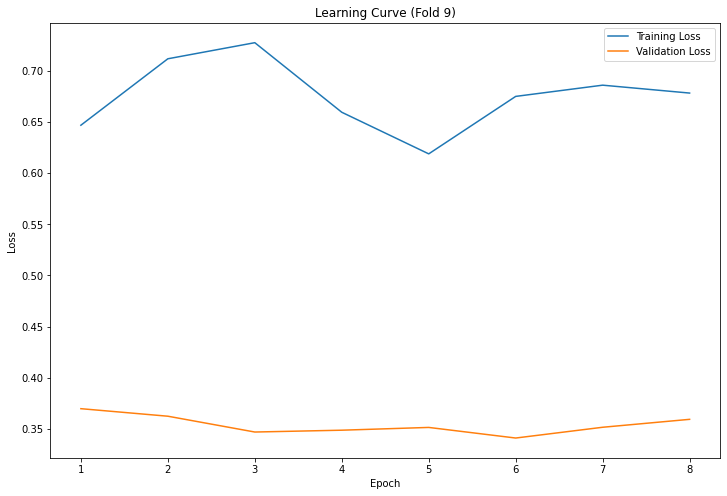

--------------DONE TRAINING MODEL FOR EarningsPerShareDiluted--------------




In [ ]:
# Define variables
batch_size = 32
epochs=40
initial_lr=2e-5
eps=1e-8
patience=5
cv=10
# Name metric
file = fb_files[5]
metric_name = file.split('.')[0].split('_')[0]

print(f"--------------START TRAINING MODEL FOR {metric_name}--------------")

# Read csv file
df = pd.read_csv(fb_path + file)

# Load model and tokenizer
model, tokenizer = finbert_regressor()
model.to(device)

# Scale data
scaler = StandardScaler()
df['target'] = scaler.fit_transform(df['target'].values.reshape(-1, 1))

# Prepare dataset
dataset = prepare_labeled_datasets(tokenizer, model, 300, df['text'].values.tolist(), df['target'].values.tolist()) 

# Train model
best_model_overall, best_val_loss_overall, best_fold_overall, all_train_losses, all_val_losses, training_stats  = train_finbert_regressor(model, tokenizer, dataset, 
                                                                                           epochs=epochs, initial_lr=initial_lr, 
                                                                                           eps=eps, cv=cv)



# Save models
# Check if model exists
if best_model_overall is None:
   print("No model available")
else:
   # Present results from the best model
   print("Results from the best model")
   print(f"Fold with best validation RSE: {best_fold_overall}")
   print("Best validation RSE: {0:.2f}".format(best_val_loss_overall)) 

   plot_learning_curve(training_stats,best_fold_overall)
   print(f"--------------DONE TRAINING MODEL FOR {metric_name}--------------")
   print("\n")
   # Save models
   hub_path = 'lenguyen/' + 'finbert_' + metric_name  
   model.push_to_hub(hub_path)
   tokenizer.push_to_hub(hub_path)
   
   # Save scaler locally
   joblib.dump(scaler, f'../models/finbert_data/{metric_name}_scaler.pkl')

--------------START TRAINING MODEL FOR EarningsPerShareDiluted--------------


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at yiyanghkust/finbert-pretrain and are newly initialized: ['transformer.layer.11.output_layer_norm.weight', 'transformer.layer.9.attention.k_lin.weight', 'transformer.layer.0.attention.v_lin.bias', 'transformer.layer.2.output_layer_norm.bias', 'transformer.layer.0.ffn.lin2.weight', 'transformer.layer.7.attention.q_lin.weight', 'classifier.bias', 'transformer.layer.4.ffn.lin1.weight', 'transformer.layer.4.attention.q_lin.weight', 'transformer.layer.0.sa_layer_norm.bias', 'transformer.layer.6.ffn.lin1.weight', 'transformer.layer.7.ffn.lin1.bias', 'transformer.layer.9.output_layer_norm.weight', 'transformer.layer.8.attention.out_lin.bias', 'transformer.layer.3.attention.out_lin.bias', 'transformer.layer.2.output_layer_norm.weight', 'transformer.layer.6.attention.out_lin.bias', 'transformer.layer.5.attention.k_lin.bias', 'transformer.layer.1.attention.out_lin.weight', 'transformer.layer.2.ff

Fold 1


  8%|▊         | 3/40 [00:22<04:35,  7.45s/it]


Early stopping at epoch 4 in fold 1
Fold 1 - Best Validation Loss: 1.0945401589075725 at Epoch: 1
Fold 2


 10%|█         | 4/40 [00:28<04:12,  7.02s/it]


Early stopping at epoch 5 in fold 2
Fold 2 - Best Validation Loss: 1.1929575204849243 at Epoch: 2
Fold 3


 10%|█         | 4/40 [00:28<04:13,  7.04s/it]


Early stopping at epoch 5 in fold 3
Fold 3 - Best Validation Loss: 1.4557166894276936 at Epoch: 2
Fold 4


 32%|███▎      | 13/40 [01:18<02:43,  6.07s/it]


Early stopping at epoch 14 in fold 4
Fold 4 - Best Validation Loss: 1.1114761233329773 at Epoch: 11
Fold 5


 18%|█▊        | 7/40 [00:45<03:32,  6.44s/it]


Early stopping at epoch 8 in fold 5
Fold 5 - Best Validation Loss: 0.6557679871718088 at Epoch: 5
Fold 6


 28%|██▊       | 11/40 [01:07<02:57,  6.13s/it]


Early stopping at epoch 12 in fold 6
Fold 6 - Best Validation Loss: 0.4205954273541768 at Epoch: 9
Fold 7


 10%|█         | 4/40 [00:28<04:14,  7.06s/it]


Early stopping at epoch 5 in fold 7
Fold 7 - Best Validation Loss: 0.6284427245457967 at Epoch: 2
Fold 8


 10%|█         | 4/40 [00:28<04:16,  7.12s/it]


Early stopping at epoch 5 in fold 8
Fold 8 - Best Validation Loss: 21.128248622020084 at Epoch: 2
Fold 9


 22%|██▎       | 9/40 [00:57<03:16,  6.33s/it]


Early stopping at epoch 10 in fold 9
Fold 9 - Best Validation Loss: 0.4634626905123393 at Epoch: 7
Fold 10


 35%|███▌      | 14/40 [01:24<02:36,  6.01s/it]

Early stopping at epoch 15 in fold 10
Fold 10 - Best Validation Loss: 0.5025853514671326 at Epoch: 12
Results from the best model
Fold with best validation RSE: 6
Best validation RSE: 0.42


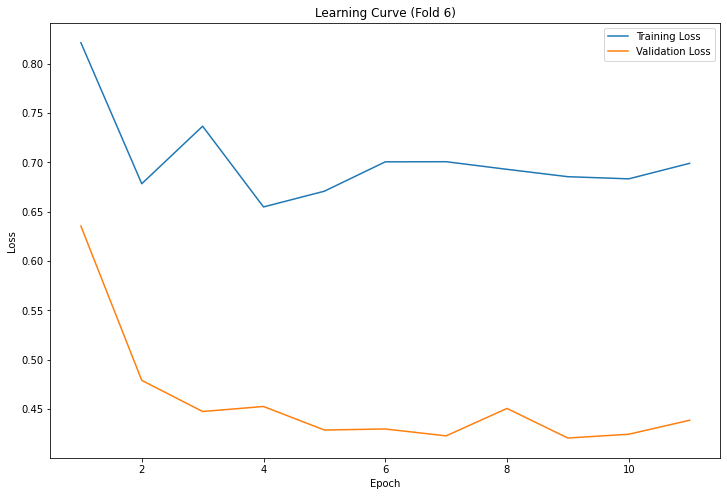

--------------DONE TRAINING MODEL FOR EarningsPerShareDiluted--------------




In [31]:
# Define variables
batch_size = 32
epochs=40
initial_lr=2e-5
eps=1e-8
patience=5
cv=10


# Name metric
file = fb_files[5]
metric_name = file.split('.')[0].split('_')[0]

print(f"--------------START TRAINING MODEL FOR {metric_name}--------------")

# Read csv file
df = pd.read_csv(fb_path + file)

# Load model and tokenizer
model, tokenizer = finbert_regressor()
model.to(device)

# Prepare dataset
dataset = prepare_labeled_datasets(tokenizer, model, 300, df['text'].values.tolist(), df['target'].values.tolist()) 

# Train model
best_model_overall, best_val_loss_overall, best_fold_overall, all_train_losses, all_val_losses, training_stats  = train_finbert_regressor(model, tokenizer, dataset, 
                                                                                          epochs=epochs, initial_lr=initial_lr, 
                                                                                          eps=eps, cv=cv)  

# Present results from the best model
print("Results from the best model")
print(f"Fold with best validation RSE: {best_fold_overall}")
print("Best validation RSE: {0:.2f}".format(best_val_loss_overall)) 

plot_learning_curve(training_stats,best_fold_overall)
print(f"--------------DONE TRAINING MODEL FOR {metric_name}--------------")
print("\n")